In [1]:
#@title Dataset Definition

"""Smart Buildings Dataset implementation, including loading and downloading."""


import json
import pickle
import shutil
import numpy as np
import requests





class SmartBuildingsDataset:
 """Smart Buildings Dataset implementation, including loading and downloading."""


 def __init__(self, download=True):
   self.partitions = {
       "sb1": [
           "2022_a",
           "2022_b",
           "2023_a",
           "2023_b",
           "2024_a",
       ],
   }
   if download:
     self.download()


 def download(self):
   """Downloads the Smart Buildings Dataset from Google Cloud Storage."""
   print("Downloading data...")


   def download_file(url):
     local_filename = url.split("/")[-1]
     with requests.get(url, stream=True) as r:
       r.raise_for_status()
       with open(local_filename, "wb") as f:
         for chunk in r.iter_content(chunk_size=8192):
           f.write(chunk)
     return local_filename


   url = "https://storage.googleapis.com/gresearch/smart_buildings_dataset/tabular_data/sb1.zip"
   download_file(url)
   shutil.unpack_archive("sb1.zip", "sb1/")


 def get_floorplan(self, building):
   """Gets the floorplan and device layout map for a specific building.


   Args:
     building: The name of the building.


   Returns:
     A tuple containing the floorplan and device layout map.
   """
   if building not in self.partitions.keys():
     raise ValueError("invalid building")
   floorplan = np.load(f"./{building}/tabular/floorplan.npy")

   def gdrive_to_direct_url(share_url):
        file_id = share_url.split('/d/')[1].split('/')[0]
        return f"https://drive.google.com/uc?export=download&id={file_id}"
   share_url = "https://drive.google.com/file/d/19W4exC1IfIpx6x_agZy3HO1ARXdxKnic/view?usp=sharing"
   direct_url = gdrive_to_direct_url(share_url)
   response = requests.get(direct_url)
   device_layout_map = response.json()

   return floorplan, device_layout_map


 def get_building_data(self, building, partition):
   """Gets the data for a specific building and partition.


   Args:
     building: The name of the building.
     partition: The name of the partition.


   Returns:
     A tuple containing the data and metadata.
   """
   if building not in self.partitions.keys():
     raise ValueError("invalid building")
   if partition not in self.partitions[building]:
     raise ValueError("invalid partition")
   path = f"./{building}/tabular/{building}/{partition}/"


   data = np.load(path + "data.npy.npz")
   metadata = pickle.load(open(path + "metadata.pickle", "rb"))


   if "device_infos" not in metadata.keys():
     metadata["device_infos"] = pickle.load(
         open(f"./{building}/tabular/device_info_dicts.pickle", "rb")
     )
   if "zone_infos" not in metadata.keys():
     metadata["zone_infos"] = pickle.load(
         open(f"./{building}/tabular/zone_info_dicts.pickle", "rb")
     )
   return data, metadata


In [2]:
#@title Data download and splitting

ds = SmartBuildingsDataset()

# training data: Jan-June 2022
data, metadata = ds.get_building_data("sb1","2022_a")
floorplan, device_layout_map = ds.get_floorplan("sb1")

# validation data: July-December 2022
data_val, metadata_val = ds.get_building_data("sb1","2022_b")
floorplan_val, device_layout_map_val = ds.get_floorplan("sb1")

# lets split validation data into things to predict, and exogenous variables
indexes = [v for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" in k]
temp_data = data_val['observation_value_matrix'][:, indexes]
matching_items = [(k, v) for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" in k]
temp_data_ids = {k: i for i, (k, v) in enumerate(matching_items)}

indexes = [v for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" not in k]
exogenous_observation_data = data_val['observation_value_matrix'][:, indexes]
matching_items = [(k, v) for k, v in metadata_val['observation_ids'].items() if "zone_air_temperature_sensor" not in k]
exogenous_observation_data_ids = {k: i for i, (k, v) in enumerate(matching_items)}

initial_condition = temp_data[0]

In [3]:
# Train data:
data['observation_value_matrix']
metadata["observation_ids"]
metadata["observation_timestamps"]

data['action_value_matrix']
metadata["action_ids"]

floorplan
device_layout_map
metadata["device_infos"]

# Validation data:
data_val['action_value_matrix']
metadata_val["action_ids"]
metadata_val["observation_timestamps"]
floorplan
device_layout_map

exogenous_observation_data
exogenous_observation_data_ids
initial_condition

# Predict:
temp_data
temp_data_ids







{'2760348383893915@zone_air_temperature_sensor': 0,
 '2562701969438717@zone_air_temperature_sensor': 1,
 '2806035809406684@zone_air_temperature_sensor': 2,
 '2790439929052995@zone_air_temperature_sensor': 3,
 '2628534928204590@zone_air_temperature_sensor': 4,
 '2535333053617205@zone_air_temperature_sensor': 5,
 '2619255661594253@zone_air_temperature_sensor': 6,
 '2618781414146613@zone_air_temperature_sensor': 7,
 '2613654138967436@zone_air_temperature_sensor': 8,
 '2762982574975969@zone_air_temperature_sensor': 9,
 '2578499186529204@zone_air_temperature_sensor': 10,
 '2693289483686059@zone_air_temperature_sensor': 11,
 '2549483694528743@zone_air_temperature_sensor': 12,
 '2614466029028994@zone_air_temperature_sensor': 13,
 '2760979770441910@zone_air_temperature_sensor': 14,
 '2732460999450017@zone_air_temperature_sensor': 15,
 '2549513081490212@zone_air_temperature_sensor': 16,
 '2737293899563066@zone_air_temperature_sensor': 17,
 '2710040674126014@zone_air_temperature_sensor': 18,
 '2

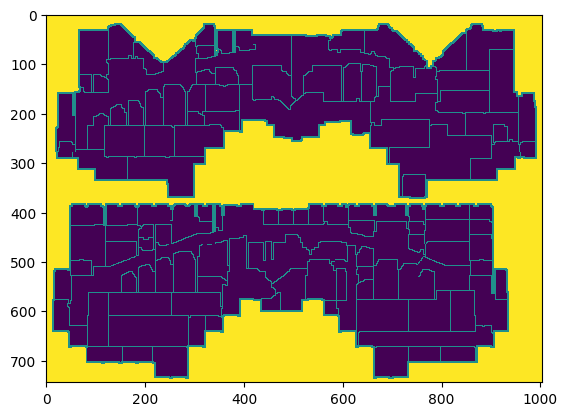

In [4]:
from matplotlib import pyplot as plt
plt.imshow(floorplan, interpolation='nearest')
plt.show()

In [5]:
metadata["device_infos"][0]


{'device_id': '202194278473007104',
 'namespace': 'PHRED',
 'code': 'SB1:AHU:AC-2',
 'zone_id': '',
 'device_type': 6,
 'observable_fields': {'building_air_static_pressure_sensor': 1,
  'outside_air_flowrate_sensor': 1,
  'supply_fan_speed_percentage_command': 1,
  'supply_air_temperature_sensor': 1,
  'supply_fan_speed_frequency_sensor': 1,
  'supply_air_static_pressure_setpoint': 1,
  'return_air_temperature_sensor': 1,
  'mixed_air_temperature_setpoint': 1,
  'exhaust_fan_speed_percentage_command': 1,
  'exhaust_fan_speed_frequency_sensor': 1,
  'outside_air_damper_percentage_command': 1,
  'mixed_air_temperature_sensor': 1,
  'exhaust_air_damper_percentage_command': 1,
  'cooling_percentage_command': 1,
  'outside_air_flowrate_setpoint': 1,
  'supply_air_temperature_setpoint': 1,
  'building_air_static_pressure_setpoint': 1,
  'supply_air_static_pressure_sensor': 1},
 'action_fields': {'exhaust_air_damper_percentage_command': 1,
  'supply_air_temperature_setpoint': 1,
  'supply_fan

In [6]:
metadata["zone_infos"][0]


{'zone_id': 'rooms/1002000133978',
 'building_id': 'buildings/3616672508',
 'zone_description': 'SB1-2-C2054',
 'area': 0.0,
 'zone_type': 1,
 'floor': 2,
 'devices': ['2618581107144046', '2696593986887004']}

In [7]:
temp_data.shape

(53292, 123)

In [8]:
print((temp_data==0).sum()/(temp_data.shape[0]*temp_data.shape[1]))

0.10406372865800263


In [9]:
indexes1 = [v for k, v in metadata['observation_ids'].items() if "zone_air_temperature_sensor" in k]
temp_data_train = data['observation_value_matrix'][:, indexes1]

(temp_data_train==0).sum()/(temp_data_train.shape[0]*temp_data_train.shape[1])

0.28568066460576663

In [10]:
import numpy as np
import pandas as pd
import xgboost as xgb
import optuna
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.multioutput import MultiOutputRegressor
from datetime import datetime, timedelta
import warnings
import gc
warnings.filterwarnings('ignore')

# GPU memory management
def clear_gpu_memory():
    """Clear GPU memory cache"""
    try:
        import torch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.synchronize()
    except ImportError:
        pass
    
    # Force garbage collection
    gc.collect()

def kelvin_to_fahrenheit(temp_k):
    """Convert temperature from Kelvin to Fahrenheit"""
    return (temp_k - 273.15) * 9/5 + 32

def preprocess_temperatures(data_matrix, metadata_dict, data_name="data"):
    """
    Preprocess temperature data by converting Kelvin to Fahrenheit
    
    Args:
        data_matrix: numpy array of observation data
        metadata_dict: dictionary containing observation_ids mapping
        data_name: string name for logging purposes

    Returns:
        data_matrix: preprocessed data matrix (modified in-place)
        temp_conversion_info: dictionary with conversion statistics
    """
    
    print(f"\n=== Temperature Preprocessing for {data_name} ===")
    
    # Find temperature-related observation IDs
    temp_sensor_ids = []
    temp_setpoint_ids = []
    
    for obs_name, obs_idx in metadata_dict.items():
        if any(temp_keyword in obs_name.lower() for temp_keyword in [
            'temperature_sensor', 'temperature_setpoint', 
            'air_temperature', 'mixed_air_temperature',
            'supply_air_temperature', 'return_air_temperature',
            'discharge_air_temperature', 'outside_air_temperature'
        ]):
            if 'sensor' in obs_name:
                temp_sensor_ids.append((obs_name, obs_idx))
            elif 'setpoint' in obs_name:
                temp_setpoint_ids.append((obs_name, obs_idx))
            else:
                # Default to sensor if unclear
                temp_sensor_ids.append((obs_name, obs_idx))
    
    print(f"Found {len(temp_sensor_ids)} temperature sensors")
    print(f"Found {len(temp_setpoint_ids)} temperature setpoints")
    
    conversion_info = {
        'sensors_converted': 0,
        'setpoints_converted': 0,
        'total_values_converted': 0,
        'sensor_details': [],
        'setpoint_details': []
    }
    
    # Process temperature sensors
    for obs_name, obs_idx in temp_sensor_ids:
        temp_values = data_matrix[:, obs_idx]
        
        # Find values that might be in Kelvin (> 273)
        kelvin_mask = temp_values > 273
        kelvin_count = np.sum(kelvin_mask)
        
        if kelvin_count > 0:
            print(f"  Converting {kelvin_count}/{len(temp_values)} values in {obs_name}")
            print(f"    Before: min={temp_values[kelvin_mask].min():.2f}, max={temp_values[kelvin_mask].max():.2f}")
            
            # Convert Kelvin to Fahrenheit
            data_matrix[kelvin_mask, obs_idx] = kelvin_to_fahrenheit(temp_values[kelvin_mask])
            
            print(f"    After:  min={data_matrix[kelvin_mask, obs_idx].min():.2f}, max={data_matrix[kelvin_mask, obs_idx].max():.2f}")
            
            conversion_info['sensors_converted'] += 1
            conversion_info['total_values_converted'] += kelvin_count
            conversion_info['sensor_details'].append({
                'name': obs_name,
                'index': obs_idx,
                'values_converted': kelvin_count,
                'total_values': len(temp_values)
            })
    
    # Process temperature setpoints
    for obs_name, obs_idx in temp_setpoint_ids:
        temp_values = data_matrix[:, obs_idx]
        
        # Find values that might be in Kelvin (> 273)
        kelvin_mask = temp_values > 273
        kelvin_count = np.sum(kelvin_mask)
        
        if kelvin_count > 0:
            print(f"  Converting {kelvin_count}/{len(temp_values)} values in {obs_name}")
            print(f"    Before: min={temp_values[kelvin_mask].min():.2f}, max={temp_values[kelvin_mask].max():.2f}")
            
            # Convert Kelvin to Fahrenheit
            data_matrix[kelvin_mask, obs_idx] = kelvin_to_fahrenheit(temp_values[kelvin_mask])
            
            print(f"    After:  min={data_matrix[kelvin_mask, obs_idx].min():.2f}, max={data_matrix[kelvin_mask, obs_idx].max():.2f}")
            
            conversion_info['setpoints_converted'] += 1
            conversion_info['total_values_converted'] += kelvin_count
            conversion_info['setpoint_details'].append({
                'name': obs_name,
                'index': obs_idx,
                'values_converted': kelvin_count,
                'total_values': len(temp_values)
            })
    
    print(f"\nConversion Summary for {data_name}:")
    print(f"  Temperature sensors converted: {conversion_info['sensors_converted']}")
    print(f"  Temperature setpoints converted: {conversion_info['setpoints_converted']}")
    print(f"  Total values converted: {conversion_info['total_values_converted']}")
    
    return data_matrix, conversion_info

def preprocess_temp_data_array(temp_data_array, temp_data_ids, data_name="temperature data"):
    """
    Preprocess temperature data array (for validation temperature data)
    
    Args:
        temp_data_array: numpy array of temperature data
        temp_data_ids: dictionary mapping temperature sensor names to column indices
        data_name: string name for logging purposes

    Returns:
        temp_data_array: preprocessed temperature data (modified in-place)
        conversion_info: dictionary with conversion statistics
    """
    
    print(f"\n=== Temperature Preprocessing for {data_name} ===")
    
    conversion_info = {
        'sensors_converted': 0,
        'total_values_converted': 0,
        'sensor_details': []
    }
    
    for sensor_name, col_idx in temp_data_ids.items():
        temp_values = temp_data_array[:, col_idx]
        
        # Find values that might be in Kelvin (> 273)
        kelvin_mask = temp_values > 273
        kelvin_count = np.sum(kelvin_mask)
        
        if kelvin_count > 0:
            print(f"  Converting {kelvin_count}/{len(temp_values)} values in {sensor_name}")
            print(f"    Before: min={temp_values[kelvin_mask].min():.2f}, max={temp_values[kelvin_mask].max():.2f}")
            
            # Convert Kelvin to Fahrenheit
            temp_data_array[kelvin_mask, col_idx] = kelvin_to_fahrenheit(temp_values[kelvin_mask])
            
            print(f"    After:  min={temp_data_array[kelvin_mask, col_idx].min():.2f}, max={temp_data_array[kelvin_mask, col_idx].max():.2f}")
            
            conversion_info['sensors_converted'] += 1
            conversion_info['total_values_converted'] += kelvin_count
            conversion_info['sensor_details'].append({
                'name': sensor_name,
                'index': col_idx,
                'values_converted': kelvin_count,
                'total_values': len(temp_values)
            })
    
    print(f"\nConversion Summary for {data_name}:")
    print(f"  Temperature sensors converted: {conversion_info['sensors_converted']}")
    print(f"  Total values converted: {conversion_info['total_values_converted']}")
    
    return temp_data_array, conversion_info

def remove_zero_temperature_readings(obs_matrix, temp_data_matrix, exog_data_matrix, 
                                   timestamps_train, timestamps_val, metadata_obs_ids, 
                                   temp_data_ids, exog_data_ids):
    """
    Remove rows where temperature sensors have zero values from both training and validation sets
    
    Args:
        obs_matrix: training observation matrix
        temp_data_matrix: validation temperature data matrix  
        exog_data_matrix: validation exogenous data matrix
        timestamps_train: training timestamps
        timestamps_val: validation timestamps
        metadata_obs_ids: training observation IDs mapping
        temp_data_ids: validation temperature IDs mapping
        exog_data_ids: validation exogenous IDs mapping

    Returns:
        Cleaned datasets with zero temperature readings removed
    """
    
    print("\n" + "="*60)
    print("REMOVING ZERO TEMPERATURE READINGS")
    print("="*60)
    
    # 1. Clean training data
    print("\nCleaning training data...")
    
    # Find temperature sensor columns in training data
    train_temp_indices = [v for k, v in metadata_obs_ids.items() 
                         if "zone_air_temperature_sensor" in k]
    
    # Get temperature data from training matrix
    train_temp_data = obs_matrix[:, train_temp_indices]
    
    # Find rows where ANY temperature sensor has zero values
    zero_mask_train = np.any(train_temp_data == 0, axis=1)
    valid_mask_train = ~zero_mask_train
    
    print(f"  Original training data: {len(obs_matrix)} rows")
    print(f"  Rows with zero temperatures: {np.sum(zero_mask_train)}")
    print(f"  Rows to keep: {np.sum(valid_mask_train)}")
    print(f"  Percentage kept: {np.sum(valid_mask_train)/len(obs_matrix)*100:.1f}%")
    
    # Apply mask to training data
    obs_matrix_clean = obs_matrix[valid_mask_train]
    timestamps_train_clean = [timestamps_train[i] for i in range(len(timestamps_train)) if valid_mask_train[i]]
    
    # 2. Clean validation data
    print("\nCleaning validation data...")
    
    # Find rows where ANY temperature sensor has zero values in validation
    zero_mask_val = np.any(temp_data_matrix == 0, axis=1)
    valid_mask_val = ~zero_mask_val
    
    print(f"  Original validation data: {len(temp_data_matrix)} rows")
    print(f"  Rows with zero temperatures: {np.sum(zero_mask_val)}")
    print(f"  Rows to keep: {np.sum(valid_mask_val)}")
    print(f"  Percentage kept: {np.sum(valid_mask_val)/len(temp_data_matrix)*100:.1f}%")
    
    # Apply mask to validation data
    temp_data_clean = temp_data_matrix[valid_mask_val]
    exog_data_clean = exog_data_matrix[valid_mask_val]
    timestamps_val_clean = [timestamps_val[i] for i in range(len(timestamps_val)) if valid_mask_val[i]]
    
    print(f"\nData cleaning summary:")
    print(f"  Training: {len(obs_matrix)} -> {len(obs_matrix_clean)} rows")
    print(f"  Validation: {len(temp_data_matrix)} -> {len(temp_data_clean)} rows")
    
    return (obs_matrix_clean, temp_data_clean, exog_data_clean, 
            timestamps_train_clean, timestamps_val_clean)

# ===== MAIN PREPROCESSING STEP =====
print("Starting temperature preprocessing...")

# First, extract arrays from NpzFile objects to make them modifiable
print("Extracting arrays from NpzFile objects...")

# Extract training observation matrix (make it modifiable)
train_obs_matrix = np.array(data['observation_value_matrix'])
print(f"Training observation matrix shape: {train_obs_matrix.shape}")

# Extract validation exogenous data (make it modifiable) 
val_exog_matrix = np.array(exogenous_observation_data)
print(f"Validation exogenous matrix shape: {val_exog_matrix.shape}")

# Extract validation temperature data (make it modifiable)
val_temp_matrix = np.array(temp_data)
print(f"Validation temperature matrix shape: {val_temp_matrix.shape}")

# 1. Preprocess training data (observation_value_matrix)
print("\n" + "="*60)
print("PREPROCESSING TRAINING DATA")
print("="*60)

train_obs_matrix, train_conversion_info = preprocess_temperatures(
    train_obs_matrix, 
    metadata['observation_ids'], 
    "training data"
)

# 2. Preprocess validation exogenous data
print("\n" + "="*60)
print("PREPROCESSING VALIDATION EXOGENOUS DATA")
print("="*60)

val_exog_matrix, val_exog_conversion_info = preprocess_temperatures(
    val_exog_matrix, 
    exogenous_observation_data_ids, 
    "validation exogenous data"
)

# 3. Preprocess validation temperature data (targets)
print("\n" + "="*60)
print("PREPROCESSING VALIDATION TEMPERATURE DATA (TARGETS)")
print("="*60)

val_temp_matrix, val_temp_conversion_info = preprocess_temp_data_array(
    val_temp_matrix, 
    temp_data_ids, 
    "validation temperature targets"
)

# 4. Remove zero temperature readings from both training and validation
print("\n" + "="*60)
print("REMOVING ZERO TEMPERATURE READINGS")
print("="*60)

# Remove rows with zero temperature readings
(train_obs_matrix_clean, val_temp_matrix_clean, val_exog_matrix_clean, 
 timestamps_train_clean, timestamps_val_clean) = remove_zero_temperature_readings(
    train_obs_matrix, val_temp_matrix, val_exog_matrix,
    metadata["observation_timestamps"], metadata_val["observation_timestamps"],
    metadata['observation_ids'], temp_data_ids, exogenous_observation_data_ids
)

print("\n" + "="*60)
print("TEMPERATURE PREPROCESSING COMPLETED")
print("="*60)

# Print overall summary
total_converted = (train_conversion_info['total_values_converted'] + 
                  val_exog_conversion_info['total_values_converted'] + 
                  val_temp_conversion_info['total_values_converted'])

print(f"\nOVERALL CONVERSION SUMMARY:")
print(f"  Training data: {train_conversion_info['total_values_converted']} values converted")
print(f"  Validation exogenous: {val_exog_conversion_info['total_values_converted']} values converted")
print(f"  Validation targets: {val_temp_conversion_info['total_values_converted']} values converted")
print(f"  TOTAL: {total_converted} temperature values converted from Kelvin to Fahrenheit")

print(f"\nOVERALL ZERO REMOVAL SUMMARY:")
print(f"  Training data: {len(train_obs_matrix)} -> {len(train_obs_matrix_clean)} rows")
print(f"  Validation data: {len(val_temp_matrix)} -> {len(val_temp_matrix_clean)} rows")

# Update the global variables to use the cleaned, preprocessed data
print("\nUpdating global variables with cleaned and preprocessed data...")
exogenous_observation_data = val_exog_matrix_clean
temp_data = val_temp_matrix_clean

print("Preprocessing complete! Now starting model training with Grouped PCA...")

# ===== MODEL WITH GROUPED PCA =====

class SmartBuildingsPredictor:
    def __init__(self, use_gpu=True, components_per_group=5):
        self.use_gpu = use_gpu
        self.components_per_group = components_per_group
        self.models = {}  # Will store 24 hourly models
        self.scalers = {}  # Will store scalers for each hour
        self.group_pcas = {}  # Will store PCA transformers for each group
        self.imputer = None  # Will store imputer for NaN handling
        self.feature_groups = {}  # Will store feature group definitions
        self.exog_feature_names = None  # Will store original exogenous feature names
        self.feature_columns = None
        self.temp_columns = None
        
    def interpolate_zeros(self, data):
        """Interpolate zero values in training data"""
        data_df = pd.DataFrame(data)
        # Replace zeros with NaN for interpolation
        data_df = data_df.replace(0, np.nan)
        # Forward fill then backward fill
        data_df = data_df.fillna(method='ffill').fillna(method='bfill')
        # If still NaN, fill with column mean
        data_df = data_df.fillna(data_df.mean())
        return data_df.values
    
    def handle_nan_values(self, exog_data, is_training=True):
        """Handle NaN values in exogenous data"""
        nan_count = np.isnan(exog_data).sum()
        
        if is_training:
            # Always fit imputer on training data (even if no NaN values)
            # This ensures imputer is available for test data that might have NaN values
            self.imputer = SimpleImputer(strategy='mean')
            exog_data_clean = self.imputer.fit_transform(exog_data)
            print(f"Fitted imputer on training data (found {nan_count} NaN values, {nan_count/exog_data.size*100:.2f}%)")
        else:
            # Use fitted imputer on test data
            if self.imputer is None:
                raise ValueError("Imputer not fitted yet. Train model first.")
            print(f"Found {nan_count} NaN values in test data ({nan_count/exog_data.size*100:.2f}%)")
            exog_data_clean = self.imputer.transform(exog_data)
            print("Applied fitted imputer to test data")
        
        nan_count_after = np.isnan(exog_data_clean).sum()
        print(f"NaN values after imputation: {nan_count_after}")
        return exog_data_clean
    
    def create_temporal_features(self, timestamps):
        """Create temporal dummy features"""
        features = []
        
        for ts in timestamps:
            # Handle both pandas Timestamp and Unix timestamp
            if hasattr(ts, 'hour'):  # pandas Timestamp
                dt = ts
            else:  # Unix timestamp
                dt = datetime.fromtimestamp(ts)
            
            # Hour of day (0-23)
            hour = dt.hour
            
            # Time of day categories
            if 6 <= hour < 12:
                time_of_day = [1, 0, 0, 0]  # morning
            elif 12 <= hour < 18:
                time_of_day = [0, 1, 0, 0]  # day
            elif 18 <= hour < 22:
                time_of_day = [0, 0, 1, 0]  # evening
            else:
                time_of_day = [0, 0, 0, 1]  # night
            
            # Season
            month = dt.month
            if month in [12, 1, 2]:
                season = [1, 0, 0, 0]  # winter
            elif month in [3, 4, 5]:
                season = [0, 1, 0, 0]  # spring
            elif month in [6, 7, 8]:
                season = [0, 0, 1, 0]  # summer
            else:
                season = [0, 0, 0, 1]  # fall
            
            # Weekend/weekday
            is_weekend = 1 if dt.weekday() >= 5 else 0
            
            # Day of week (one-hot)
            day_of_week = [0] * 7
            day_of_week[dt.weekday()] = 1
            
            # Combine all features
            feature_row = [hour] + time_of_day + season + [is_weekend] + day_of_week
            features.append(feature_row)
        
        feature_names = ['hour'] + \
                       ['morning', 'day', 'evening', 'night'] + \
                       ['winter', 'spring', 'summer', 'fall'] + \
                       ['is_weekend'] + \
                       [f'dow_{i}' for i in range(7)]
        
        return np.array(features), feature_names
    
    def create_device_to_zone_mapping(self):
        """Create mapping from device IDs to zone IDs using metadata"""
        device_to_zone = {}
        
        # Check if we have zone info available
        if 'metadata' in globals() and 'zone_infos' in metadata:
            zone_infos = metadata['zone_infos']
            print(f"Found {len(zone_infos)} zones in metadata")
            
            for zone_info in zone_infos:
                zone_id = zone_info.get('zone_id', 'unknown_zone')
                zone_description = zone_info.get('zone_description', zone_id)
                devices = zone_info.get('devices', [])
                
                # Map each device to this zone
                for device_id in devices:
                    device_to_zone[device_id] = {
                        'zone_id': zone_id,
                        'zone_description': zone_description,
                        'floor': zone_info.get('floor', 0),
                        'zone_type': zone_info.get('zone_type', 0)
                    }
            
            print(f"Mapped {len(device_to_zone)} devices to zones")
        else:
            print("No zone metadata found, using device-based grouping as fallback")
        
        return device_to_zone
    
    def create_feature_groups(self, exog_data, exog_metadata_dict):
        """Create feature groups based on actual zones and domain knowledge"""
        print("Creating zone-aware feature groups using actual zone metadata...")
        
        # Create device to zone mapping
        device_to_zone = self.create_device_to_zone_mapping()
        
        # Create feature names for mapping
        feature_names = []
        if isinstance(exog_metadata_dict, dict):
            name_to_idx = {name: idx for name, idx in exog_metadata_dict.items()}
            feature_names = list(name_to_idx.keys())
        else:
            feature_names = [f'feature_{i}' for i in range(exog_data.shape[1])]
        
        # Initialize zone-domain groups
        zone_domain_groups = {}
        
        print("Analyzing features and mapping to zones...")
        
        # Process each feature
        for i, feature_name in enumerate(feature_names):
            name_lower = feature_name.lower()
            
            # Extract device ID (before @ symbol)
            device_id = "unknown_device"
            if '@' in feature_name:
                device_id = feature_name.split('@')[0]
            
            # Map device to zone
            zone_info = device_to_zone.get(device_id, {
                'zone_id': f'device_{device_id}',
                'zone_description': f'Device_{device_id}',
                'floor': 0,
                'zone_type': 0
            })
            
            zone_id = zone_info['zone_id']
            
            # Determine domain
            domain = 'other'
            if any(keyword in name_lower for keyword in [
                'air_temperature', 'mixed_air_temperature', 
                'supply_air_temperature', 'return_air_temperature',
                'discharge_air_temperature', 'outside_air_temperature'
            ]):
                domain = 'air_temperatures'
            
            elif any(keyword in name_lower for keyword in [
                'water_temperature', 'supply_water_temperature',
                'return_water_temperature', 'hot_water', 'chilled_water'
            ]):
                domain = 'water_temperatures'
            
            elif any(keyword in name_lower for keyword in [
                'setpoint', '_setpoint', 'temperature_setpoint'
            ]):
                domain = 'setpoints'
            
            elif any(keyword in name_lower for keyword in [
                'command', 'percentage_command', 'damper', 'fan_speed',
                'valve', 'position', 'cooling', 'heating'
            ]):
                domain = 'control_commands'
            
            elif any(keyword in name_lower for keyword in [
                'outside_air', 'outdoor', 'ambient', 'humidity', 
                'dewpoint', 'wetbulb', 'pressure_sensor', 'static_pressure'
            ]):
                domain = 'environmental'
            
            elif any(keyword in name_lower for keyword in [
                'flow', 'flowrate', 'pressure', 'static', 'differential'
            ]):
                domain = 'flow_pressure'
            
            # Create zone-domain group name
            # Use zone description if available, otherwise zone_id
            zone_name = zone_info.get('zone_description', zone_id)
            # Clean zone name for group naming
            zone_name = zone_name.replace('/', '_').replace('-', '_').replace(' ', '_')
            group_name = f"{domain}_{zone_name}"
            
            # Add feature to group
            if group_name not in zone_domain_groups:
                zone_domain_groups[group_name] = []
            zone_domain_groups[group_name].append(i)
        
        # Also create building-wide groups for environmental features
        # These affect all zones similarly
        environmental_features = []
        for i, feature_name in enumerate(feature_names):
            name_lower = feature_name.lower()
            if any(keyword in name_lower for keyword in [
                'outside_air', 'outdoor', 'ambient', 'humidity', 
                'dewpoint', 'wetbulb'
            ]):
                environmental_features.append(i)
        
        if environmental_features:
            zone_domain_groups['environmental_building_wide'] = environmental_features
        
        # Filter out groups with too few features (less than 2)
        zone_domain_groups = {name: indices for name, indices in zone_domain_groups.items() 
                            if len(indices) >= 2}
        
        # Store the final groups
        self.feature_groups = zone_domain_groups
        
        # Print detailed group summary
        print(f"\nZone-aware feature groups created:")
        total_features = 0
        domain_counts = {}
        zone_counts = {}
        
        for group_name, indices in self.feature_groups.items():
            parts = group_name.split('_', 1)
            domain = parts[0] if len(parts) > 0 else 'unknown'
            zone = parts[1] if len(parts) > 1 else 'unknown'
            
            domain_counts[domain] = domain_counts.get(domain, 0) + len(indices)
            zone_counts[zone] = zone_counts.get(zone, 0) + 1
            
            total_features += len(indices)
        
        # Show sample of groups
        group_items = list(self.feature_groups.items())
        sample_size = min(10, len(group_items))
        print(f"  Sample groups (showing {sample_size} of {len(self.feature_groups)}):")
        for group_name, indices in group_items[:sample_size]:
            print(f"    {group_name}: {len(indices)} features")
        
        if len(group_items) > sample_size:
            print(f"    ... and {len(group_items) - sample_size} more groups")
        
        print(f"\nSummary:")
        print(f"  Total feature groups: {len(self.feature_groups)}")
        print(f"  Total features categorized: {total_features}/{exog_data.shape[1]}")
        print(f"  Features per domain: {dict(domain_counts)}")
        print(f"  Unique zones found: {len(set(zone_counts.keys()))}")
        print(f"  Average features per group: {total_features/len(self.feature_groups):.1f}")
        
        return self.feature_groups
    
    def fit_grouped_pca(self, exog_data, exog_metadata_dict):
        """Fit PCA separately for each zone-aware feature group"""
        print(f"\nFitting Zone-Aware Grouped PCA (max {self.components_per_group} components per group)...")
        
        # Create zone-aware feature groups
        self.create_feature_groups(exog_data, exog_metadata_dict)
        
        total_components = 0
        successful_groups = 0
        
        for group_name, feature_indices in self.feature_groups.items():
            if len(feature_indices) == 0:
                continue
                
            # Extract group data
            group_data = exog_data[:, feature_indices]
            
            # Determine number of components (min of requested and available)
            n_components = min(self.components_per_group, len(feature_indices), group_data.shape[0]-1)
            
            if n_components <= 0:
                print(f"  Skipping {group_name}: insufficient data")
                continue
            
            # Fit PCA for this group
            group_pca = PCA(n_components=n_components, random_state=42)
            group_pca.fit(group_data)
            
            self.group_pcas[group_name] = group_pca
            
            explained_variance = np.sum(group_pca.explained_variance_ratio_)
            total_components += n_components
            successful_groups += 1
            
            # Only print details for first few groups to avoid spam
            if successful_groups <= 10:
                print(f"  {group_name}: {len(feature_indices)} features → {n_components} components "
                      f"(explained variance: {explained_variance:.3f})")
            elif successful_groups == 11:
                print(f"  ... (showing first 10 groups, {len(self.feature_groups) - 10} more groups fitted)")
        
        print(f"\nZone-Aware Grouped PCA Summary:")
        print(f"  Original features: {exog_data.shape[1]}")
        print(f"  Total PCA components: {total_components}")
        print(f"  Successful feature groups: {successful_groups}")
        print(f"  Average components per group: {total_components/successful_groups:.1f}")
        print(f"  Dimensionality reduction: {exog_data.shape[1]} → {total_components}")
        print(f"  Reduction factor: {exog_data.shape[1]/total_components:.1f}x")
    
    def transform_grouped_pca(self, exog_data):
        """Transform exogenous data using fitted grouped PCA"""
        if not self.group_pcas:
            raise ValueError("Grouped PCA not fitted yet. Call fit_grouped_pca first.")
        
        transformed_groups = []
        group_feature_names = []
        
        for group_name, group_pca in self.group_pcas.items():
            # Get feature indices for this group
            feature_indices = self.feature_groups[group_name]
            
            # Extract and transform group data
            group_data = exog_data[:, feature_indices]
            group_transformed = group_pca.transform(group_data)
            
            transformed_groups.append(group_transformed)
            
            # Create feature names for this group
            n_components = group_transformed.shape[1]
            group_names = [f'{group_name}_pc{i}' for i in range(n_components)]
            group_feature_names.extend(group_names)
        
        # Combine all transformed groups
        if transformed_groups:
            combined_transformed = np.hstack(transformed_groups)
        else:
            combined_transformed = np.array([]).reshape(exog_data.shape[0], 0)
        
        return combined_transformed, group_feature_names
    
    def prepare_data(self, obs_data, exog_data, timestamps, temp_data=None, is_training=True):
        """Prepare data with interpolation, NaN handling, Grouped PCA, and feature engineering"""
        
        # Interpolate training data
        if is_training:
            obs_data = self.interpolate_zeros(obs_data) if obs_data is not None else None
            temp_data = self.interpolate_zeros(temp_data) if temp_data is not None else None
        
        # Create temporal features
        temporal_features, temporal_names = self.create_temporal_features(timestamps)
        
        # Apply NaN handling and Grouped PCA to exogenous features
        if exog_data is not None:
            # Handle NaN values first
            exog_data_clean = self.handle_nan_values(exog_data, is_training=is_training)
            
            if is_training and not self.group_pcas:
                # Fit Grouped PCA on training data
                # We need the metadata dict for feature grouping
                exog_metadata = exogenous_observation_data_ids if 'exogenous_observation_data_ids' in globals() else None
                self.fit_grouped_pca(exog_data_clean, exog_metadata)
            
            # Transform exogenous data using Grouped PCA
            exog_pca, exog_names = self.transform_grouped_pca(exog_data_clean)
            
            # Combine PCA features and temporal features
            X = np.hstack([exog_pca, temporal_features])
            feature_names = exog_names + temporal_names
        else:
            X = temporal_features
            feature_names = temporal_names
        
        return X, feature_names, temp_data
    
    def create_hourly_bins(self, X, y, timestamps):
        """Create hourly bins for data"""
        hourly_data = {}
        
        for i, ts in enumerate(timestamps):
            # Handle both pandas Timestamp and Unix timestamp
            if hasattr(ts, 'hour'):  # pandas Timestamp
                hour = ts.hour
            else:  # Unix timestamp
                hour = datetime.fromtimestamp(ts).hour
                
            if hour not in hourly_data:
                hourly_data[hour] = {'X': [], 'y': []}
            hourly_data[hour]['X'].append(X[i])
            if y is not None:
                hourly_data[hour]['y'].append(y[i])
        
        # Convert to numpy arrays
        for hour in hourly_data:
            hourly_data[hour]['X'] = np.array(hourly_data[hour]['X'])
            if y is not None:
                hourly_data[hour]['y'] = np.array(hourly_data[hour]['y'])
        
        return hourly_data
    
    def optimize_hyperparameters(self, X_train, y_train, trial):
        """Optuna objective function for hyperparameter optimization"""
        
        # Clear GPU memory before optimization
        clear_gpu_memory()
        
        params = {
            'objective': 'reg:absoluteerror',  # MAE objective
            'tree_method': 'gpu_hist' if self.use_gpu else 'hist',
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),  # Reduced for memory
            'max_depth': trial.suggest_int('max_depth', 3, 6),  # Reduced for memory
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0),
            'random_state': 42,
            'n_jobs': 1
        }
        
        # Add GPU-specific memory management parameters
        if self.use_gpu:
            params.update({
                'gpu_id': 0,
                'max_bin': 256,  # Reduce memory usage
                'single_precision_histogram': True  # Use less memory
            })
        
        base_model = xgb.XGBRegressor(**params)
        model = MultiOutputRegressor(base_model, n_jobs=1)
        
        # Simple train/validation split for optimization
        split_idx = int(0.8 * len(X_train))
        X_tr, X_val = X_train[:split_idx], X_train[split_idx:]
        y_tr, y_val = y_train[:split_idx], y_train[split_idx:]
        
        try:
            model.fit(X_tr, y_tr)
            y_pred = model.predict(X_val)
            result = mean_absolute_error(y_val, y_pred)
            
            # Clear memory after each trial
            del model, base_model
            clear_gpu_memory()
            
            return result
            
        except Exception as e:
            print(f"Trial failed with error: {e}")
            clear_gpu_memory()
            return float('inf')  # Return worst possible score
    
    def train_hourly_models(self, X_train, y_train, timestamps_train, n_trials=5):
        """Train 24 hourly XGBoost models with hyperparameter optimization"""
        
        # Clear GPU memory before starting
        clear_gpu_memory()
        
        # Create hourly bins
        hourly_train_data = self.create_hourly_bins(X_train, y_train, timestamps_train)
        
        print(f"Training {len(hourly_train_data)} hourly models...")
        
        for hour in range(24):
            if hour not in hourly_train_data:
                print(f"No data for hour {hour}, skipping...")
                continue
                
            print(f"Training model for hour {hour}...")
            
            # Clear GPU memory before each model
            clear_gpu_memory()
            
            X_hour = hourly_train_data[hour]['X']
            y_hour = hourly_train_data[hour]['y']
            
            if len(X_hour) < 10:
                print(f"Too few samples for hour {hour} ({len(X_hour)}), skipping...")
                continue
            
            # Scale features
            scaler = StandardScaler()
            X_hour_scaled = scaler.fit_transform(X_hour)
            self.scalers[hour] = scaler
            
            # Optimize hyperparameters
            study = optuna.create_study(direction='minimize', study_name=f'hour_{hour}')
            
            def objective(trial):
                return self.optimize_hyperparameters(X_hour_scaled, y_hour, trial)
            
            try:
                study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
                
                # Train final model with best parameters
                best_params = study.best_params
                best_params.update({
                    'objective': 'reg:absoluteerror',
                    'tree_method': 'gpu_hist' if self.use_gpu else 'hist',
                    'random_state': 42,
                    'n_jobs': 1
                })
                
                # Add GPU-specific parameters for final model
                if self.use_gpu:
                    best_params.update({
                        'gpu_id': 0,
                        'max_bin': 256,
                        'single_precision_histogram': True
                    })
                
                base_model = xgb.XGBRegressor(**best_params)
                model = MultiOutputRegressor(base_model, n_jobs=1)
                model.fit(X_hour_scaled, y_hour)
                
                self.models[hour] = model
                
                print(f"Hour {hour} - Best MAE: {study.best_value:.4f}")
                
            except Exception as e:
                print(f"Error training hour {hour}: {e}")
                print(f"Skipping hour {hour}")
                continue
            
            # Clear memory after each hour
            clear_gpu_memory()
        
        print(f"Training completed. {len(self.models)} models trained.")
        
        # Final memory cleanup
        clear_gpu_memory()
    
    def predict(self, X_test, timestamps_test):
        """Make predictions using hourly models"""
        
        # Clear GPU memory before prediction
        clear_gpu_memory()
        
        first_model = self.models[list(self.models.keys())[0]]
        n_outputs = len(first_model.estimators_)
        
        predictions = np.zeros((len(X_test), n_outputs))
        
        # Create hourly bins for test data
        hourly_test_data = self.create_hourly_bins(X_test, None, timestamps_test)
        
        for hour in hourly_test_data:
            if hour not in self.models:
                available_hours = list(self.models.keys())
                hour_to_use = min(available_hours, key=lambda x: abs(x - hour))
                print(f"Using model for hour {hour_to_use} instead of hour {hour}")
            else:
                hour_to_use = hour
            
            X_hour = hourly_test_data[hour]['X']
            X_hour_scaled = self.scalers[hour_to_use].transform(X_hour)
            
            try:
                hour_predictions = self.models[hour_to_use].predict(X_hour_scaled)
                
                # Map predictions back to original indices
                hour_indices = []
                for i, ts in enumerate(timestamps_test):
                    if hasattr(ts, 'hour'):
                        ts_hour = ts.hour
                    else:
                        ts_hour = datetime.fromtimestamp(ts).hour
                        
                    if ts_hour == hour:
                        hour_indices.append(i)
                
                for i, idx in enumerate(hour_indices):
                    predictions[idx] = hour_predictions[i]
                    
            except Exception as e:
                print(f"Error predicting for hour {hour}: {e}")
                continue
        
        # Clear memory after prediction
        clear_gpu_memory()
        
        return predictions
    
    def evaluate_predictions(self, y_true, y_pred, timestamps_test):
        """Evaluate predictions for different time periods"""
        results = {}
        
        # Convert timestamps to datetime for easier handling
        dates = []
        for ts in timestamps_test:
            if hasattr(ts, 'to_pydatetime'):
                dates.append(ts.to_pydatetime())
            elif hasattr(ts, 'hour'):
                dates.append(ts)
            else:
                dates.append(datetime.fromtimestamp(ts))
        
        start_date = min(dates)
        
        # Define evaluation periods
        periods = {
            'first_week': timedelta(days=7),
            'first_2_weeks': timedelta(days=14),
            'first_month': timedelta(days=30),
            'first_3_months': timedelta(days=90),
            'entire_period': timedelta(days=365)
        }
        
        for period_name, period_length in periods.items():
            end_date = start_date + period_length
            
            period_indices = [i for i, date in enumerate(dates) if date <= end_date]
            
            if period_indices:
                y_true_period = y_true[period_indices]
                y_pred_period = y_pred[period_indices]
                
                mae = mean_absolute_error(y_true_period, y_pred_period)
                results[period_name] = mae
                print(f"{period_name}: MAE = {mae:.4f}")
        
        return results

# Main execution function
def run_smart_buildings_model():
    """Main function to run the complete model"""
    
    # Clear GPU memory at start
    clear_gpu_memory()
    
    print("Initializing Smart Buildings Predictor with Zone-Aware Grouped PCA...")
    predictor = SmartBuildingsPredictor(use_gpu=True, components_per_group=3)
    
    # Prepare training data
    print("Preparing training data...")
    
    # Extract training temperature data (target) from cleaned preprocessed data
    train_temp_indices = [v for k, v in metadata['observation_ids'].items() 
                         if "zone_air_temperature_sensor" in k]
    train_temp_data = train_obs_matrix_clean[:, train_temp_indices]
    
    # Extract training exogenous data from cleaned preprocessed data
    train_exog_indices = [v for k, v in metadata['observation_ids'].items() 
                         if "zone_air_temperature_sensor" not in k]
    train_exog_data = train_obs_matrix_clean[:, train_exog_indices]
    
    # Prepare training features and targets using cleaned timestamps
    X_train, feature_names, y_train = predictor.prepare_data(
        None, train_exog_data, timestamps_train_clean, 
        train_temp_data, is_training=True
    )
    
    predictor.feature_columns = feature_names
    
    print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Feature names: {len(feature_names)} features")
    
    # Debug: Check if feature count is reasonable
    if X_train.shape[1] > 500:
        print(f"WARNING: Large feature count ({X_train.shape[1]}). Consider reducing components_per_group.")
    elif X_train.shape[1] < 50:
        print(f"WARNING: Very small feature count ({X_train.shape[1]}). Consider increasing components_per_group.")
    
    # Clear memory before training
    clear_gpu_memory()
    
    # Train models using cleaned timestamps with 5 trials
    predictor.train_hourly_models(X_train, y_train, timestamps_train_clean, n_trials=5)
    
    # Clear memory after training
    clear_gpu_memory()
    
    # Prepare test data using cleaned validation data
    print("Preparing test data...")
    X_test, _, _ = predictor.prepare_data(
        None, exogenous_observation_data, timestamps_val_clean, 
        None, is_training=False
    )
    
    print(f"Test data shape: {X_test.shape}")
    
    # Make predictions using cleaned validation timestamps
    print("Making predictions...")
    predictions = predictor.predict(X_test, timestamps_val_clean)
    
    print(f"Predictions shape: {predictions.shape}")
    print(f"True values shape: {temp_data.shape}")
    
    # Evaluate results using cleaned validation timestamps
    print("\nEvaluation Results:")
    print("=" * 50)
    results = predictor.evaluate_predictions(
        temp_data, predictions, timestamps_val_clean
    )
    
    # Final memory cleanup
    clear_gpu_memory()
    
    return predictor, predictions, results

# Run the model
if __name__ == "__main__":
    predictor, predictions, results = run_smart_buildings_model()

Starting temperature preprocessing...
Extracting arrays from NpzFile objects...
Training observation matrix shape: (51852, 1198)
Validation exogenous matrix shape: (53292, 1075)
Validation temperature matrix shape: (53292, 123)

PREPROCESSING TRAINING DATA

=== Temperature Preprocessing for training data ===
Found 246 temperature sensors
Found 357 temperature setpoints
  Converting 36921/51852 values in 202194278473007104@return_air_temperature_sensor
    Before: min=284.43, max=307.39
    After:  min=52.30, max=93.64
  Converting 36921/51852 values in 202194278473007104@mixed_air_temperature_sensor
    Before: min=281.87, max=305.57
    After:  min=47.69, max=90.35
  Converting 36921/51852 values in 202194278473007104@supply_air_temperature_sensor
    Before: min=280.11, max=305.19
    After:  min=44.53, max=89.67
  Converting 36758/51852 values in 2291864505572917248@outside_air_wetbulb_temperature_sensor
    Before: min=273.01, max=293.60
    After:  min=31.74, max=68.82
  Convertin

[I 2025-07-07 01:41:19,810] A new study created in memory with name: hour_0


Training 24 hourly models...
Training model for hour 0...


[I 2025-07-07 01:43:38,312] Trial 0 finished with value: 1.3592597945045253 and parameters: {'n_estimators': 207, 'max_depth': 4, 'learning_rate': 0.28277022167666505, 'subsample': 0.7362249018095118, 'colsample_bytree': 0.9282424329418048, 'reg_alpha': 0.6220173676213852, 'reg_lambda': 8.803214551440881}. Best is trial 0 with value: 1.3592597945045253.
[I 2025-07-07 01:50:00,163] Trial 1 finished with value: 1.3708670031059298 and parameters: {'n_estimators': 281, 'max_depth': 6, 'learning_rate': 0.26114142260766504, 'subsample': 0.844626212756065, 'colsample_bytree': 0.9557753096357838, 'reg_alpha': 0.14626652816289562, 'reg_lambda': 3.690386131240793}. Best is trial 0 with value: 1.3592597945045253.
[I 2025-07-07 01:53:46,114] Trial 2 finished with value: 1.3888797621889157 and parameters: {'n_estimators': 229, 'max_depth': 5, 'learning_rate': 0.29879257411224724, 'subsample': 0.8510222964549351, 'colsample_bytree': 0.8814169656519051, 'reg_alpha': 0.7738863611978314, 'reg_lambda': 

Hour 0 - Best MAE: 1.2875


[I 2025-07-07 02:10:14,477] A new study created in memory with name: hour_1


Training model for hour 1...


[I 2025-07-07 02:12:35,754] Trial 0 finished with value: 1.5484075261723962 and parameters: {'n_estimators': 240, 'max_depth': 4, 'learning_rate': 0.05333457300382346, 'subsample': 0.8271536598932514, 'colsample_bytree': 0.6200015210471318, 'reg_alpha': 2.8299598981992125, 'reg_lambda': 2.043503725031164}. Best is trial 0 with value: 1.5484075261723962.
[I 2025-07-07 02:15:12,116] Trial 1 finished with value: 1.5102435408923875 and parameters: {'n_estimators': 243, 'max_depth': 4, 'learning_rate': 0.19384054514583107, 'subsample': 0.9827555082169104, 'colsample_bytree': 0.6586118601156651, 'reg_alpha': 8.871741806575496, 'reg_lambda': 8.999267488696596}. Best is trial 1 with value: 1.5102435408923875.
[I 2025-07-07 02:17:04,943] Trial 2 finished with value: 1.4711845669953338 and parameters: {'n_estimators': 234, 'max_depth': 3, 'learning_rate': 0.21538611987297046, 'subsample': 0.8503742625527284, 'colsample_bytree': 0.8027250458287605, 'reg_alpha': 4.906408712832316, 'reg_lambda': 4.

Hour 1 - Best MAE: 1.4712
Training model for hour 2...


[I 2025-07-07 02:22:54,226] A new study created in memory with name: hour_2
[I 2025-07-07 02:28:01,225] Trial 0 finished with value: 1.5981770472175463 and parameters: {'n_estimators': 287, 'max_depth': 5, 'learning_rate': 0.06609407811735718, 'subsample': 0.8119886397074807, 'colsample_bytree': 0.9614826284185773, 'reg_alpha': 9.458771025155785, 'reg_lambda': 0.31183303651394567}. Best is trial 0 with value: 1.5981770472175463.
[I 2025-07-07 02:30:20,664] Trial 1 finished with value: 2.4178761514541165 and parameters: {'n_estimators': 138, 'max_depth': 5, 'learning_rate': 0.01292411269065773, 'subsample': 0.9929926081144786, 'colsample_bytree': 0.8721252666912516, 'reg_alpha': 8.594755516009554, 'reg_lambda': 7.466331953279579}. Best is trial 0 with value: 1.5981770472175463.
[I 2025-07-07 02:34:23,965] Trial 2 finished with value: 1.5361349364822026 and parameters: {'n_estimators': 168, 'max_depth': 6, 'learning_rate': 0.11088241340540785, 'subsample': 0.9586980520360875, 'colsample_

Hour 2 - Best MAE: 1.3755
Training model for hour 3...


[I 2025-07-07 02:43:37,916] A new study created in memory with name: hour_3
[I 2025-07-07 02:45:03,917] Trial 0 finished with value: 1.679369807490693 and parameters: {'n_estimators': 135, 'max_depth': 4, 'learning_rate': 0.14711767503530163, 'subsample': 0.6783660673428951, 'colsample_bytree': 0.7702965862549304, 'reg_alpha': 1.4566790208215616, 'reg_lambda': 1.3670174399077337}. Best is trial 0 with value: 1.679369807490693.
[I 2025-07-07 02:46:58,406] Trial 1 finished with value: 1.7833813615338328 and parameters: {'n_estimators': 118, 'max_depth': 5, 'learning_rate': 0.26595398393158487, 'subsample': 0.6691916208800817, 'colsample_bytree': 0.7759624165442736, 'reg_alpha': 5.7898282473337535, 'reg_lambda': 3.89994792025748}. Best is trial 0 with value: 1.679369807490693.
[I 2025-07-07 02:47:53,511] Trial 2 finished with value: 1.809396517347473 and parameters: {'n_estimators': 113, 'max_depth': 3, 'learning_rate': 0.11976477754870589, 'subsample': 0.7345350510101011, 'colsample_bytr

Hour 3 - Best MAE: 1.6794


[I 2025-07-07 02:54:51,179] A new study created in memory with name: hour_4


Training model for hour 4...


[I 2025-07-07 02:56:15,648] Trial 0 finished with value: 1.8682936414469153 and parameters: {'n_estimators': 118, 'max_depth': 4, 'learning_rate': 0.2413304753987904, 'subsample': 0.6976462392315502, 'colsample_bytree': 0.9929142384045985, 'reg_alpha': 8.200461474058478, 'reg_lambda': 9.497324726838736}. Best is trial 0 with value: 1.8682936414469153.
[I 2025-07-07 02:58:34,034] Trial 1 finished with value: 1.6566492977727245 and parameters: {'n_estimators': 117, 'max_depth': 6, 'learning_rate': 0.13788586465764963, 'subsample': 0.6387148375240728, 'colsample_bytree': 0.9731792768914408, 'reg_alpha': 0.681938511400048, 'reg_lambda': 2.9913922263885904}. Best is trial 1 with value: 1.6566492977727245.
[I 2025-07-07 03:03:41,419] Trial 2 finished with value: 1.63299826851593 and parameters: {'n_estimators': 278, 'max_depth': 6, 'learning_rate': 0.23368013773573423, 'subsample': 0.8986892133279493, 'colsample_bytree': 0.6514963210916476, 'reg_alpha': 1.5118691506282183, 'reg_lambda': 8.07

Hour 4 - Best MAE: 1.6330


[I 2025-07-07 03:15:34,160] A new study created in memory with name: hour_5


Training model for hour 5...


[I 2025-07-07 03:17:36,333] Trial 0 finished with value: 1.534077350751571 and parameters: {'n_estimators': 289, 'max_depth': 3, 'learning_rate': 0.211570084701899, 'subsample': 0.9749313449980844, 'colsample_bytree': 0.7870783742827697, 'reg_alpha': 7.293229908501036, 'reg_lambda': 5.16927081154492}. Best is trial 0 with value: 1.534077350751571.
[I 2025-07-07 03:23:21,768] Trial 1 finished with value: 1.551125997050693 and parameters: {'n_estimators': 259, 'max_depth': 6, 'learning_rate': 0.2677795711717263, 'subsample': 0.9973104743106233, 'colsample_bytree': 0.8845166765578163, 'reg_alpha': 6.250884276642949, 'reg_lambda': 1.1245142383303248}. Best is trial 0 with value: 1.534077350751571.
[I 2025-07-07 03:25:46,932] Trial 2 finished with value: 1.5996215634880346 and parameters: {'n_estimators': 105, 'max_depth': 6, 'learning_rate': 0.2698897964482945, 'subsample': 0.8439524524116312, 'colsample_bytree': 0.9458726348564036, 'reg_alpha': 5.818304190865351, 'reg_lambda': 3.676606888

Hour 5 - Best MAE: 1.4994
Training model for hour 6...


[I 2025-07-07 03:35:09,472] A new study created in memory with name: hour_6
[I 2025-07-07 03:36:55,119] Trial 0 finished with value: 1.6945232060355604 and parameters: {'n_estimators': 243, 'max_depth': 3, 'learning_rate': 0.11121072704470486, 'subsample': 0.7782558915061734, 'colsample_bytree': 0.8379666648023946, 'reg_alpha': 9.559643144383587, 'reg_lambda': 9.276704484231823}. Best is trial 0 with value: 1.6945232060355604.
[I 2025-07-07 03:41:47,576] Trial 1 finished with value: 1.5790601744942687 and parameters: {'n_estimators': 242, 'max_depth': 6, 'learning_rate': 0.1246639771737304, 'subsample': 0.6966359661398401, 'colsample_bytree': 0.8965030543005801, 'reg_alpha': 7.18887423715371, 'reg_lambda': 0.018265333343132087}. Best is trial 1 with value: 1.5790601744942687.
[I 2025-07-07 03:44:49,003] Trial 2 finished with value: 1.624686066611616 and parameters: {'n_estimators': 155, 'max_depth': 6, 'learning_rate': 0.22990866508993718, 'subsample': 0.9921885559836611, 'colsample_by

Hour 6 - Best MAE: 1.5791
Training model for hour 7...


[I 2025-07-07 03:51:50,140] A new study created in memory with name: hour_7
[I 2025-07-07 03:52:54,741] Trial 0 finished with value: 1.6577581636470924 and parameters: {'n_estimators': 130, 'max_depth': 3, 'learning_rate': 0.18244502743604898, 'subsample': 0.6951792459114636, 'colsample_bytree': 0.8224282465652312, 'reg_alpha': 6.875545109713819, 'reg_lambda': 0.3038063634312765}. Best is trial 0 with value: 1.6577581636470924.
[I 2025-07-07 03:55:59,927] Trial 1 finished with value: 1.6063148663221671 and parameters: {'n_estimators': 239, 'max_depth': 5, 'learning_rate': 0.1564877321168614, 'subsample': 0.6085665381682952, 'colsample_bytree': 0.6267202882260402, 'reg_alpha': 3.7685777729758776, 'reg_lambda': 5.07821896447}. Best is trial 1 with value: 1.6063148663221671.
[I 2025-07-07 04:01:21,292] Trial 2 finished with value: 1.6856436737346698 and parameters: {'n_estimators': 267, 'max_depth': 6, 'learning_rate': 0.22222042757753718, 'subsample': 0.6835850294210291, 'colsample_bytre

Hour 7 - Best MAE: 1.5372


[I 2025-07-07 04:07:21,268] A new study created in memory with name: hour_8


Training model for hour 8...


[I 2025-07-07 04:11:23,125] Trial 0 finished with value: 1.7063789415900652 and parameters: {'n_estimators': 204, 'max_depth': 6, 'learning_rate': 0.29231668535391947, 'subsample': 0.9193099838440543, 'colsample_bytree': 0.6888485824232399, 'reg_alpha': 9.11908934193224, 'reg_lambda': 2.9476306520651776}. Best is trial 0 with value: 1.7063789415900652.
[I 2025-07-07 04:13:47,025] Trial 1 finished with value: 1.7713052257826918 and parameters: {'n_estimators': 194, 'max_depth': 5, 'learning_rate': 0.051567654832544545, 'subsample': 0.7135176990363296, 'colsample_bytree': 0.6401916683545309, 'reg_alpha': 6.375278221618493, 'reg_lambda': 6.009393043867309}. Best is trial 0 with value: 1.7063789415900652.
[I 2025-07-07 04:14:48,584] Trial 2 finished with value: 1.6991494646185912 and parameters: {'n_estimators': 125, 'max_depth': 3, 'learning_rate': 0.28498367388571727, 'subsample': 0.9454359693459368, 'colsample_bytree': 0.6753030036384144, 'reg_alpha': 4.86436795433062, 'reg_lambda': 9.7

Hour 8 - Best MAE: 1.6483
Training model for hour 9...


[I 2025-07-07 04:21:01,366] A new study created in memory with name: hour_9
[I 2025-07-07 04:22:33,486] Trial 0 finished with value: 1.9174146487848547 and parameters: {'n_estimators': 137, 'max_depth': 4, 'learning_rate': 0.2786130092281856, 'subsample': 0.6519332850695011, 'colsample_bytree': 0.753610518045225, 'reg_alpha': 9.52681546256598, 'reg_lambda': 7.468005023137417}. Best is trial 0 with value: 1.9174146487848547.
[I 2025-07-07 04:24:08,905] Trial 1 finished with value: 1.8264608235594377 and parameters: {'n_estimators': 205, 'max_depth': 3, 'learning_rate': 0.0935653525754519, 'subsample': 0.7483228655975446, 'colsample_bytree': 0.8609331685968871, 'reg_alpha': 6.211955319687424, 'reg_lambda': 0.7568091625069883}. Best is trial 1 with value: 1.8264608235594377.
[I 2025-07-07 04:26:18,256] Trial 2 finished with value: 1.8446345175931769 and parameters: {'n_estimators': 153, 'max_depth': 5, 'learning_rate': 0.297212518058226, 'subsample': 0.6376391711727057, 'colsample_bytree'

Hour 9 - Best MAE: 1.7299
Training model for hour 10...


[I 2025-07-07 04:37:50,204] A new study created in memory with name: hour_10
[I 2025-07-07 04:40:02,522] Trial 0 finished with value: 1.864446537894295 and parameters: {'n_estimators': 235, 'max_depth': 4, 'learning_rate': 0.20677060248736817, 'subsample': 0.9061723370385482, 'colsample_bytree': 0.6007153064025237, 'reg_alpha': 1.0091164598004347, 'reg_lambda': 9.672664130229279}. Best is trial 0 with value: 1.864446537894295.
[I 2025-07-07 04:45:02,291] Trial 1 finished with value: 1.9546225055177786 and parameters: {'n_estimators': 263, 'max_depth': 6, 'learning_rate': 0.11940931421332529, 'subsample': 0.7962847891790695, 'colsample_bytree': 0.66676381049214, 'reg_alpha': 9.916143085229477, 'reg_lambda': 4.330916618837311}. Best is trial 0 with value: 1.864446537894295.
[I 2025-07-07 04:48:20,717] Trial 2 finished with value: 1.9099895686039285 and parameters: {'n_estimators': 219, 'max_depth': 5, 'learning_rate': 0.24396921622563655, 'subsample': 0.9014617330504436, 'colsample_bytre

Hour 10 - Best MAE: 1.8644


[I 2025-07-07 04:54:45,367] A new study created in memory with name: hour_11


Training model for hour 11...


[I 2025-07-07 04:57:45,305] Trial 0 finished with value: 2.12657567698373 and parameters: {'n_estimators': 129, 'max_depth': 6, 'learning_rate': 0.11465581901330714, 'subsample': 0.603815874660879, 'colsample_bytree': 0.975368950427592, 'reg_alpha': 4.81701298116629, 'reg_lambda': 3.055570398781902}. Best is trial 0 with value: 2.12657567698373.
[I 2025-07-07 04:59:47,544] Trial 1 finished with value: 2.0629259732303122 and parameters: {'n_estimators': 188, 'max_depth': 4, 'learning_rate': 0.07236030124388253, 'subsample': 0.9796532592455842, 'colsample_bytree': 0.8526771064740002, 'reg_alpha': 5.938605714428422, 'reg_lambda': 9.436672288063882}. Best is trial 1 with value: 2.0629259732303122.
[I 2025-07-07 05:01:44,220] Trial 2 finished with value: 2.1973647744215907 and parameters: {'n_estimators': 136, 'max_depth': 5, 'learning_rate': 0.05687012387996145, 'subsample': 0.9476412083503444, 'colsample_bytree': 0.8164394208862932, 'reg_alpha': 8.458644246249412, 'reg_lambda': 7.53536945

Hour 11 - Best MAE: 1.9940
Training model for hour 12...


[I 2025-07-07 05:05:53,522] A new study created in memory with name: hour_12
[I 2025-07-07 05:11:26,532] Trial 0 finished with value: 1.857229281480809 and parameters: {'n_estimators': 262, 'max_depth': 5, 'learning_rate': 0.06661625934277463, 'subsample': 0.9315934574704838, 'colsample_bytree': 0.8690756569891822, 'reg_alpha': 7.151738194069887, 'reg_lambda': 6.1316734725627935}. Best is trial 0 with value: 1.857229281480809.
[I 2025-07-07 05:14:47,127] Trial 1 finished with value: 1.9323478461459034 and parameters: {'n_estimators': 168, 'max_depth': 5, 'learning_rate': 0.16545129504081502, 'subsample': 0.8001334493003638, 'colsample_bytree': 0.6663101977741109, 'reg_alpha': 8.818524076180244, 'reg_lambda': 8.53053784962215}. Best is trial 0 with value: 1.857229281480809.
[I 2025-07-07 05:17:53,490] Trial 2 finished with value: 1.8745377322777304 and parameters: {'n_estimators': 156, 'max_depth': 5, 'learning_rate': 0.20402416147538122, 'subsample': 0.7537245650884291, 'colsample_bytr

Hour 12 - Best MAE: 1.7614
Training model for hour 13...


[I 2025-07-07 05:23:09,965] A new study created in memory with name: hour_13
[I 2025-07-07 05:28:33,289] Trial 0 finished with value: 1.8624334282519013 and parameters: {'n_estimators': 154, 'max_depth': 6, 'learning_rate': 0.2090851469801871, 'subsample': 0.9297222871233725, 'colsample_bytree': 0.9622425842770838, 'reg_alpha': 8.127718319055996, 'reg_lambda': 1.5801131676920668}. Best is trial 0 with value: 1.8624334282519013.
[I 2025-07-07 05:31:05,081] Trial 1 finished with value: 1.7487884563866374 and parameters: {'n_estimators': 153, 'max_depth': 5, 'learning_rate': 0.2648379503424659, 'subsample': 0.9630489634527093, 'colsample_bytree': 0.6025021105988254, 'reg_alpha': 0.8584317861657801, 'reg_lambda': 1.7598883513837495}. Best is trial 1 with value: 1.7487884563866374.
[I 2025-07-07 05:34:19,051] Trial 2 finished with value: 1.8412847063335607 and parameters: {'n_estimators': 254, 'max_depth': 4, 'learning_rate': 0.07630337520366814, 'subsample': 0.8749446487234049, 'colsample_

Hour 13 - Best MAE: 1.7488
Training model for hour 14...


[I 2025-07-07 05:43:59,886] A new study created in memory with name: hour_14
[I 2025-07-07 05:46:36,670] Trial 0 finished with value: 1.3361295277336178 and parameters: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.21754464400228093, 'subsample': 0.9620859519068077, 'colsample_bytree': 0.8976019863056531, 'reg_alpha': 7.3101687308855094, 'reg_lambda': 0.7596044150534239}. Best is trial 0 with value: 1.3361295277336178.
[I 2025-07-07 05:49:26,853] Trial 1 finished with value: 1.3475719568406475 and parameters: {'n_estimators': 246, 'max_depth': 4, 'learning_rate': 0.22649384880913906, 'subsample': 0.9337889423239865, 'colsample_bytree': 0.6414712835394635, 'reg_alpha': 2.1691896037509006, 'reg_lambda': 9.222105497634814}. Best is trial 0 with value: 1.3361295277336178.
[I 2025-07-07 05:54:42,780] Trial 2 finished with value: 2.011306744779042 and parameters: {'n_estimators': 209, 'max_depth': 6, 'learning_rate': 0.010909738520963134, 'subsample': 0.9219947749761951, 'colsampl

Hour 14 - Best MAE: 1.3361


[I 2025-07-07 06:08:12,085] A new study created in memory with name: hour_15


Training model for hour 15...


[I 2025-07-07 06:10:48,003] Trial 0 finished with value: 1.6340763653223136 and parameters: {'n_estimators': 248, 'max_depth': 4, 'learning_rate': 0.012173776870574493, 'subsample': 0.8550946109950496, 'colsample_bytree': 0.6868915865126715, 'reg_alpha': 0.3440237861660202, 'reg_lambda': 5.41351292998573}. Best is trial 0 with value: 1.6340763653223136.
[I 2025-07-07 06:19:55,090] Trial 1 finished with value: 1.1515747557145326 and parameters: {'n_estimators': 297, 'max_depth': 6, 'learning_rate': 0.20537576914471034, 'subsample': 0.9224417694656537, 'colsample_bytree': 0.9311386962704932, 'reg_alpha': 4.804324810318059, 'reg_lambda': 2.036193455961562}. Best is trial 1 with value: 1.1515747557145326.
[I 2025-07-07 06:22:52,968] Trial 2 finished with value: 1.149751843435899 and parameters: {'n_estimators': 252, 'max_depth': 4, 'learning_rate': 0.29262615339543785, 'subsample': 0.8481950101968265, 'colsample_bytree': 0.7229014951922488, 'reg_alpha': 9.37529051459373, 'reg_lambda': 0.66

Hour 15 - Best MAE: 1.1498
Training model for hour 16...


[I 2025-07-07 06:33:40,428] A new study created in memory with name: hour_16
[I 2025-07-07 06:35:52,096] Trial 0 finished with value: 1.209651603137976 and parameters: {'n_estimators': 101, 'max_depth': 6, 'learning_rate': 0.1059836851294007, 'subsample': 0.7163220620069346, 'colsample_bytree': 0.6139785242402747, 'reg_alpha': 1.712913621654734, 'reg_lambda': 3.1395786052687207}. Best is trial 0 with value: 1.209651603137976.
[I 2025-07-07 06:40:17,649] Trial 1 finished with value: 1.2550812855003366 and parameters: {'n_estimators': 272, 'max_depth': 5, 'learning_rate': 0.29179815192261926, 'subsample': 0.6249016457524113, 'colsample_bytree': 0.7616302698042708, 'reg_alpha': 0.30103743660796317, 'reg_lambda': 4.93121992567149}. Best is trial 0 with value: 1.209651603137976.
[I 2025-07-07 06:42:20,021] Trial 2 finished with value: 1.7502858766523048 and parameters: {'n_estimators': 125, 'max_depth': 5, 'learning_rate': 0.01636363628396981, 'subsample': 0.8521927903831441, 'colsample_byt

Hour 16 - Best MAE: 1.2097
Training model for hour 17...


[I 2025-07-07 06:50:52,676] A new study created in memory with name: hour_17
[I 2025-07-07 06:54:02,719] Trial 0 finished with value: 1.2667866597121322 and parameters: {'n_estimators': 169, 'max_depth': 5, 'learning_rate': 0.28507095218910067, 'subsample': 0.7785649429936657, 'colsample_bytree': 0.7369518312348418, 'reg_alpha': 8.445352880014669, 'reg_lambda': 1.9003851303618151}. Best is trial 0 with value: 1.2667866597121322.
[I 2025-07-07 06:58:09,389] Trial 1 finished with value: 1.2394700099831353 and parameters: {'n_estimators': 213, 'max_depth': 5, 'learning_rate': 0.1608851428380851, 'subsample': 0.7306760007262525, 'colsample_bytree': 0.8360143046493799, 'reg_alpha': 8.423757261982534, 'reg_lambda': 4.849786501312872}. Best is trial 1 with value: 1.2394700099831353.
[I 2025-07-07 06:59:36,112] Trial 2 finished with value: 1.2634807021805265 and parameters: {'n_estimators': 114, 'max_depth': 4, 'learning_rate': 0.25257382785146415, 'subsample': 0.6609909594758904, 'colsample_b

Hour 17 - Best MAE: 1.2243


[I 2025-07-07 07:18:57,083] A new study created in memory with name: hour_18


Training model for hour 18...


[I 2025-07-07 07:25:27,476] Trial 0 finished with value: 1.3081539582124773 and parameters: {'n_estimators': 217, 'max_depth': 6, 'learning_rate': 0.24095484683548582, 'subsample': 0.9962225346002128, 'colsample_bytree': 0.876067410109448, 'reg_alpha': 6.0049294894213, 'reg_lambda': 6.411201520535792}. Best is trial 0 with value: 1.3081539582124773.
[I 2025-07-07 07:30:09,122] Trial 1 finished with value: 1.2947104359570862 and parameters: {'n_estimators': 248, 'max_depth': 5, 'learning_rate': 0.26848913039309374, 'subsample': 0.7960960698842098, 'colsample_bytree': 0.8977532121773131, 'reg_alpha': 4.013425197192224, 'reg_lambda': 0.42319453186179257}. Best is trial 1 with value: 1.2947104359570862.
[I 2025-07-07 07:34:45,923] Trial 2 finished with value: 1.312491934245399 and parameters: {'n_estimators': 272, 'max_depth': 5, 'learning_rate': 0.2490833154486457, 'subsample': 0.7867696074017682, 'colsample_bytree': 0.67913664126771, 'reg_alpha': 4.605016468025146, 'reg_lambda': 6.566706

Hour 18 - Best MAE: 1.2947
Training model for hour 19...


[I 2025-07-07 07:46:38,998] A new study created in memory with name: hour_19
[I 2025-07-07 07:49:34,101] Trial 0 finished with value: 1.3918871872678336 and parameters: {'n_estimators': 145, 'max_depth': 5, 'learning_rate': 0.23188066883638978, 'subsample': 0.7110389727283719, 'colsample_bytree': 0.873811553090942, 'reg_alpha': 9.627704336813592, 'reg_lambda': 3.181222502224031}. Best is trial 0 with value: 1.3918871872678336.
[I 2025-07-07 07:51:53,793] Trial 1 finished with value: 1.4093083316274726 and parameters: {'n_estimators': 216, 'max_depth': 4, 'learning_rate': 0.034858863711971964, 'subsample': 0.7892477976072519, 'colsample_bytree': 0.6344799214106397, 'reg_alpha': 7.154794285123759, 'reg_lambda': 1.5173805267215565}. Best is trial 0 with value: 1.3918871872678336.
[I 2025-07-07 07:53:12,413] Trial 2 finished with value: 1.3672405849143092 and parameters: {'n_estimators': 105, 'max_depth': 4, 'learning_rate': 0.16951423531892335, 'subsample': 0.7622849245574597, 'colsample_

Hour 19 - Best MAE: 1.3359
Training model for hour 20...


[I 2025-07-07 08:01:09,997] A new study created in memory with name: hour_20
[I 2025-07-07 08:02:33,842] Trial 0 finished with value: 1.331326128400546 and parameters: {'n_estimators': 163, 'max_depth': 3, 'learning_rate': 0.25937851939996037, 'subsample': 0.9651957041669488, 'colsample_bytree': 0.7836325679469331, 'reg_alpha': 1.6480324688834609, 'reg_lambda': 7.558078282116907}. Best is trial 0 with value: 1.331326128400546.
[I 2025-07-07 08:04:29,717] Trial 1 finished with value: 1.361818393492611 and parameters: {'n_estimators': 113, 'max_depth': 5, 'learning_rate': 0.26949921521917164, 'subsample': 0.7447936400013196, 'colsample_bytree': 0.762640154369473, 'reg_alpha': 1.89926655855979, 'reg_lambda': 1.6016643204703143}. Best is trial 0 with value: 1.331326128400546.
[I 2025-07-07 08:06:02,303] Trial 2 finished with value: 1.6410592348040074 and parameters: {'n_estimators': 190, 'max_depth': 3, 'learning_rate': 0.02168346382123791, 'subsample': 0.7963753028303524, 'colsample_bytre

Hour 20 - Best MAE: 1.3313


[I 2025-07-07 08:14:13,964] A new study created in memory with name: hour_21


Training model for hour 21...


[I 2025-07-07 08:15:30,752] Trial 0 finished with value: 1.3557909310839769 and parameters: {'n_estimators': 141, 'max_depth': 3, 'learning_rate': 0.16523965950520228, 'subsample': 0.8407556619391392, 'colsample_bytree': 0.6870028443155721, 'reg_alpha': 9.222890777809184, 'reg_lambda': 6.232538908344231}. Best is trial 0 with value: 1.3557909310839769.
[I 2025-07-07 08:17:22,503] Trial 1 finished with value: 1.3292371762014197 and parameters: {'n_estimators': 225, 'max_depth': 3, 'learning_rate': 0.2843976783260729, 'subsample': 0.6563018886146386, 'colsample_bytree': 0.7014089679380228, 'reg_alpha': 7.421761643619401, 'reg_lambda': 9.297968099842269}. Best is trial 1 with value: 1.3292371762014197.
[I 2025-07-07 08:19:47,722] Trial 2 finished with value: 1.3130629087471106 and parameters: {'n_estimators': 290, 'max_depth': 3, 'learning_rate': 0.09285631683792242, 'subsample': 0.6189488577573676, 'colsample_bytree': 0.9845096687818704, 'reg_alpha': 0.5895712717994874, 'reg_lambda': 5.9

Hour 21 - Best MAE: 1.3131


[I 2025-07-07 08:30:22,161] A new study created in memory with name: hour_22


Training model for hour 22...


[I 2025-07-07 08:33:35,077] Trial 0 finished with value: 1.3509931974550078 and parameters: {'n_estimators': 122, 'max_depth': 6, 'learning_rate': 0.18310688717849438, 'subsample': 0.8664744141063017, 'colsample_bytree': 0.9275204150752546, 'reg_alpha': 2.287800226532876, 'reg_lambda': 3.6794633701190924}. Best is trial 0 with value: 1.3509931974550078.
[I 2025-07-07 08:40:30,401] Trial 1 finished with value: 1.4398505784508675 and parameters: {'n_estimators': 275, 'max_depth': 6, 'learning_rate': 0.2300854349851909, 'subsample': 0.7775361772059718, 'colsample_bytree': 0.6611713192885176, 'reg_alpha': 8.628831779573392, 'reg_lambda': 7.203046678351057}. Best is trial 0 with value: 1.3509931974550078.
[I 2025-07-07 08:44:25,345] Trial 2 finished with value: 1.3766777228004532 and parameters: {'n_estimators': 159, 'max_depth': 6, 'learning_rate': 0.2270758991402749, 'subsample': 0.9004929558545933, 'colsample_bytree': 0.8351523462121919, 'reg_alpha': 3.261079220382089, 'reg_lambda': 2.10

Hour 22 - Best MAE: 1.3425
Training model for hour 23...


[I 2025-07-07 08:49:06,608] A new study created in memory with name: hour_23
[I 2025-07-07 08:52:15,664] Trial 0 finished with value: 1.4885805521458095 and parameters: {'n_estimators': 130, 'max_depth': 6, 'learning_rate': 0.2532118947310579, 'subsample': 0.9314389500159532, 'colsample_bytree': 0.6203071242812885, 'reg_alpha': 3.1704760820408726, 'reg_lambda': 6.762428590431904}. Best is trial 0 with value: 1.4885805521458095.
[I 2025-07-07 08:53:53,532] Trial 1 finished with value: 1.411015284698876 and parameters: {'n_estimators': 114, 'max_depth': 4, 'learning_rate': 0.2607672821008874, 'subsample': 0.8326477031843946, 'colsample_bytree': 0.976521783419416, 'reg_alpha': 2.9643760697599806, 'reg_lambda': 3.6254087384934115}. Best is trial 1 with value: 1.411015284698876.
[I 2025-07-07 08:56:03,063] Trial 2 finished with value: 1.4321282764001118 and parameters: {'n_estimators': 176, 'max_depth': 4, 'learning_rate': 0.09198206052852101, 'subsample': 0.6677158461155001, 'colsample_byt

Hour 23 - Best MAE: 1.4110
Training completed. 24 models trained.
Preparing test data...
Found 116 NaN values in test data (0.00%)
Applied fitted imputer to test data
NaN values after imputation: 0
Test data shape: (33877, 809)
Making predictions...
Predictions shape: (33877, 123)
True values shape: (33877, 123)

Evaluation Results:
first_week: MAE = 1.2042
first_2_weeks: MAE = 1.2042
first_month: MAE = 1.3784
first_3_months: MAE = 1.2279
entire_period: MAE = 1.2273


Saving prediction results and creating diagnostic plots...
1. Saving results to files...
✓ Saved predictions1.npy, actual_values1.npy, timestamps_val_clean1.npy
✓ Saved smart_buildings_predictions1.pkl (complete results)

2. Analyzing performance by sensor...
Best performing sensor: 16286830034440683520@zone_air_temperature_sensor (MAE: 0.6658°F)
Worst performing sensor: 2779591174908667@zone_air_temperature_sensor (MAE: 2.4457°F)

3. Creating diagnostic plots...


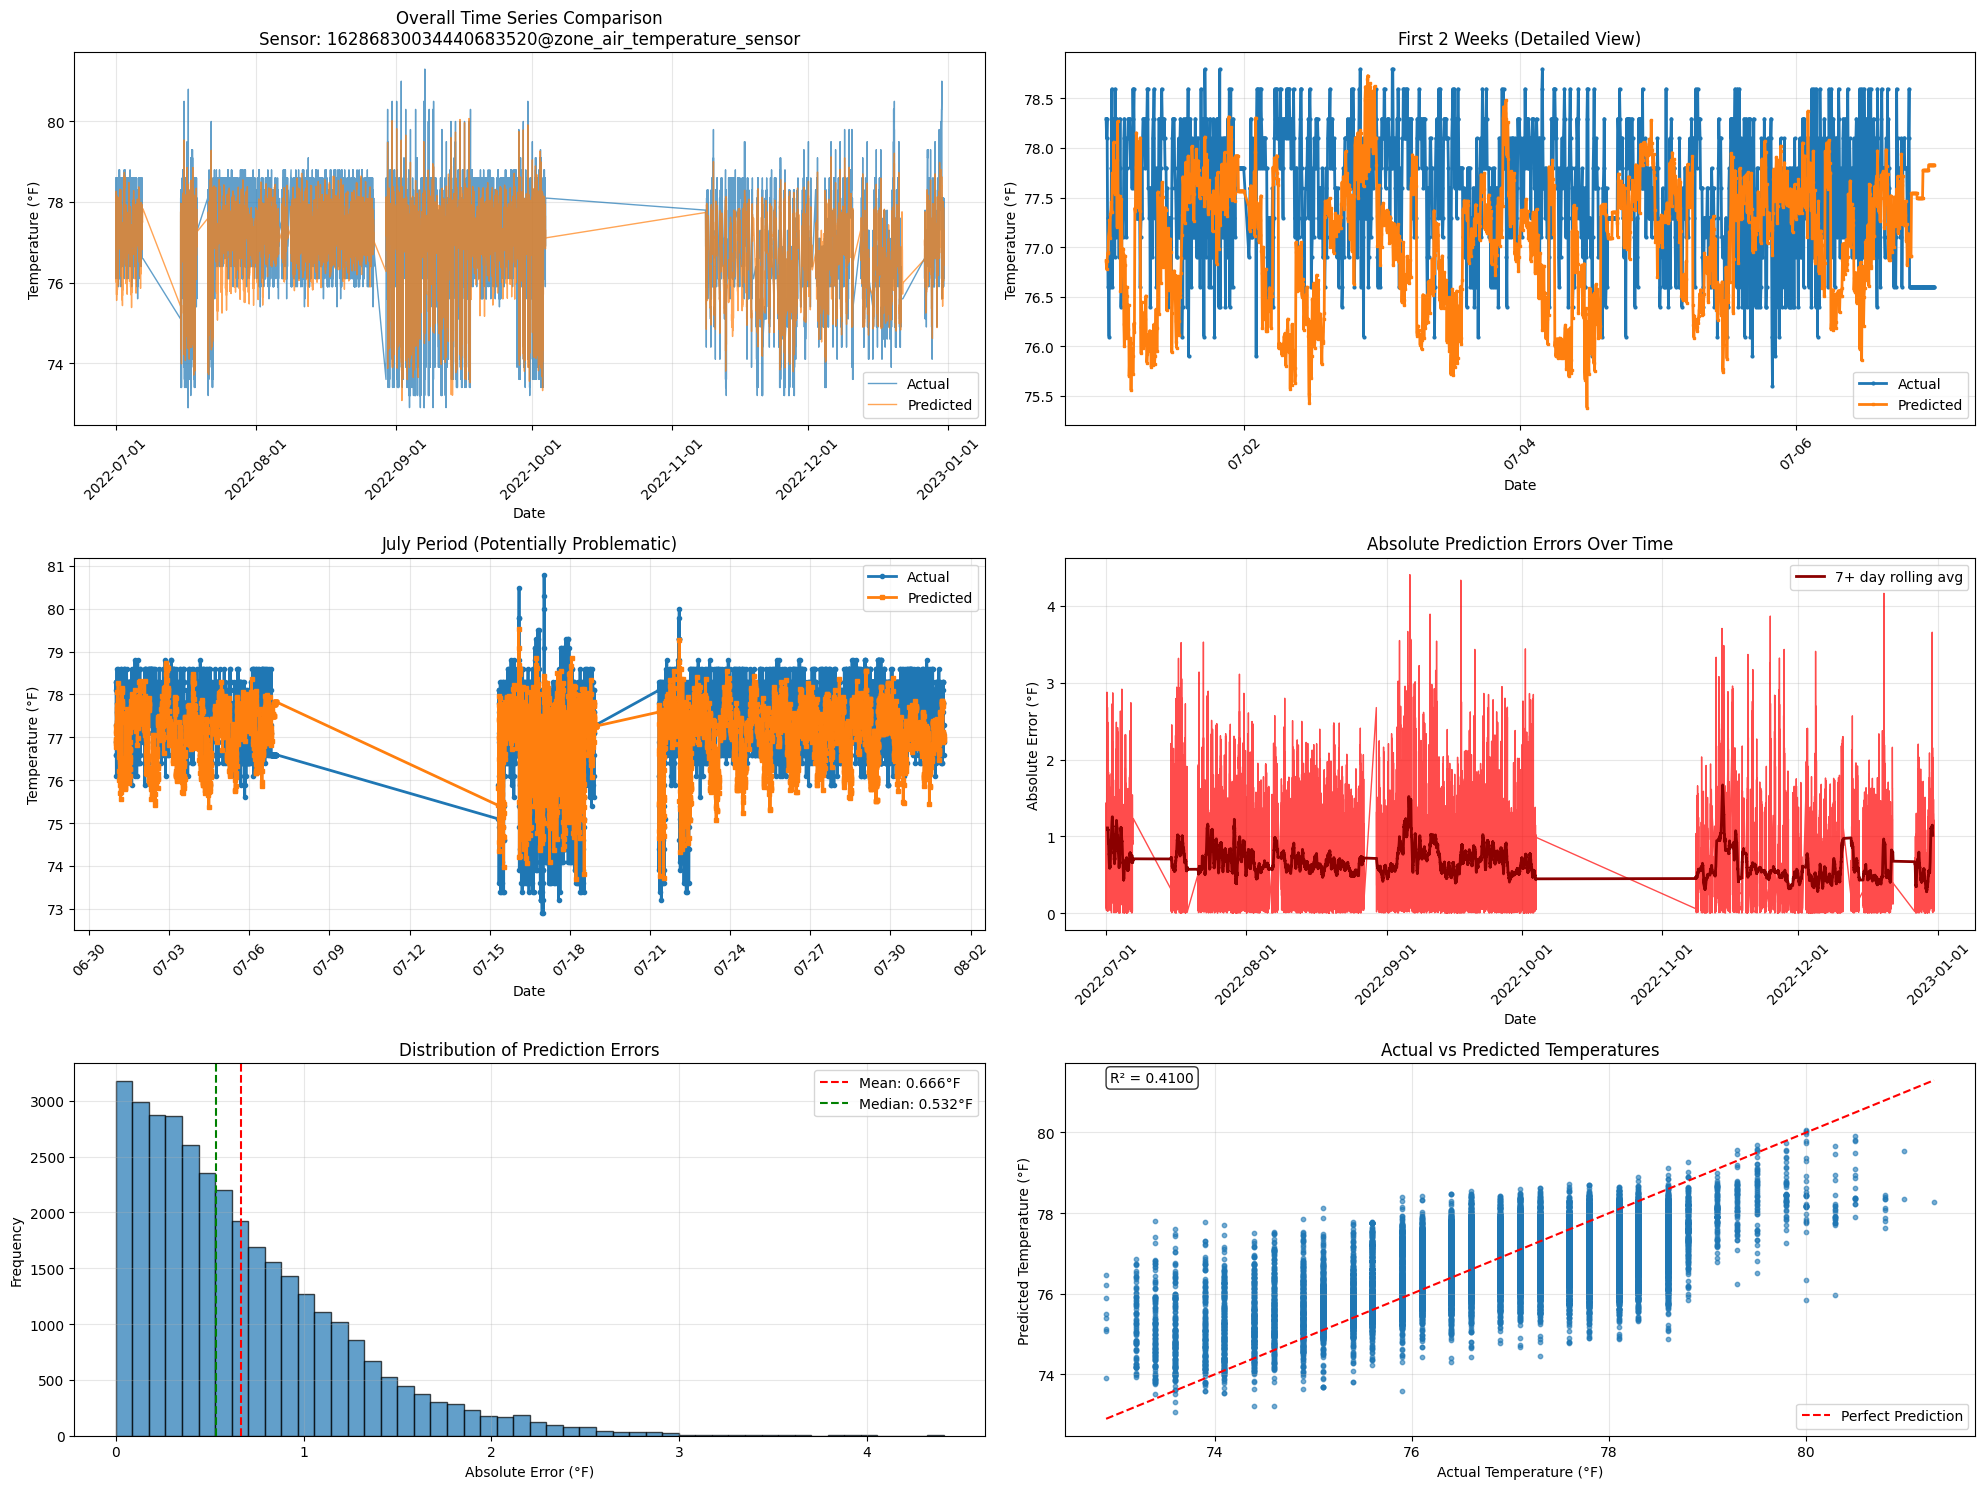


4. Analyzing data quality by month...

Monthly Data Quality Analysis:
Month      Count    Zero_Act  Zero_Pred  MAE      Quality
--------------------------------------------------------------------------------
2022-07    6428     0         0          0.765    GOOD
2022-08    7528     0         0          0.633    GOOD
2022-09    8547     0         0          0.732    GOOD
2022-10    864      0         0          0.614    GOOD
2022-11    4231     0         0          0.633    GOOD
2022-12    6279     0         0          0.543    GOOD

Analysis complete!
- Results saved to: smart_buildings_predictions1.pkl
- Plots saved to: prediction_analysis1.png
- Best sensor for analysis: 16286830034440683520@zone_air_temperature_sensor
- Overall MAE for best sensor: 0.6658°F

5. Verification of saved data:
- Predictions shape: (33877, 123)
- Actual values shape: (33877, 123)
- Timestamps count: 33877
- Sensors count: 123
- Date range: 2022-07-01 00:00:00+00:00 to 2022-12-31 00:55:00+00:00
✓ Success

In [11]:
# =============================================================================
# SAVE RESULTS AND CREATE DIAGNOSTIC PLOTS
# =============================================================================

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error
import seaborn as sns

print("Saving prediction results and creating diagnostic plots...")

# =============================================================================
# 1. SAVE ALL IMPORTANT VARIABLES TO AVOID LOSING THEM
# =============================================================================

print("1. Saving results to files...")

# Create a results dictionary with all important variables
results_dict = {
    'predictions': predictions,
    'actual_values': temp_data,
    'timestamps_val_clean': timestamps_val_clean,
    'temp_data_ids': temp_data_ids,
    'exogenous_observation_data': exogenous_observation_data,
    'results_summary': results,
    'predictor_models': predictor.models if 'predictor' in globals() else None,
    'predictor_scalers': predictor.scalers if 'predictor' in globals() else None,
    'feature_columns': predictor.feature_columns if 'predictor' in globals() else None,
    'complete_predictor': predictor if 'predictor' in globals() else None  # Full object
}

# Save to pickle file
with open('smart_buildings_predictions1.pkl', 'wb') as f:
    pickle.dump(results_dict, f)

# Also save as separate numpy arrays for easy loading
np.save('predictions1.npy', predictions)
np.save('actual_values1.npy', temp_data)
np.save('timestamps_val_clean1.npy', timestamps_val_clean)

print("✓ Saved predictions1.npy, actual_values1.npy, timestamps_val_clean1.npy")
print("✓ Saved smart_buildings_predictions1.pkl (complete results)")

# =============================================================================
# 2. ANALYZE PERFORMANCE BY SENSOR AND TIME PERIOD
# =============================================================================

print("\n2. Analyzing performance by sensor...")

# Calculate MAE for each sensor
sensor_maes = {}
sensor_names = list(temp_data_ids.keys())

for sensor_name, col_idx in temp_data_ids.items():
    actual_sensor = temp_data[:, col_idx]
    pred_sensor = predictions[:, col_idx]
    
    # Remove any remaining zeros or NaNs for fair comparison
    valid_mask = (actual_sensor != 0) & (pred_sensor != 0) & \
                 ~np.isnan(actual_sensor) & ~np.isnan(pred_sensor)
    
    if np.sum(valid_mask) > 0:
        mae = mean_absolute_error(actual_sensor[valid_mask], pred_sensor[valid_mask])
        sensor_maes[sensor_name] = mae
    else:
        sensor_maes[sensor_name] = np.inf

# Find best and worst sensors
best_sensor = min(sensor_maes, key=sensor_maes.get)
worst_sensor = max(sensor_maes, key=sensor_maes.get)

print(f"Best performing sensor: {best_sensor} (MAE: {sensor_maes[best_sensor]:.4f}°F)")
print(f"Worst performing sensor: {worst_sensor} (MAE: {sensor_maes[worst_sensor]:.4f}°F)")

# =============================================================================
# 3. CREATE TIME SERIES PLOTS FOR ANALYSIS
# =============================================================================

print("\n3. Creating diagnostic plots...")

# Convert timestamps to datetime objects for plotting
plot_timestamps = []
for ts in timestamps_val_clean:
    if hasattr(ts, 'to_pydatetime'):
        plot_timestamps.append(ts.to_pydatetime())
    elif hasattr(ts, 'hour'):
        plot_timestamps.append(ts)
    else:
        plot_timestamps.append(datetime.fromtimestamp(ts))

plot_timestamps = np.array(plot_timestamps)

# Select sensor for detailed analysis (best performing one)
selected_sensor = best_sensor
selected_col_idx = temp_data_ids[selected_sensor]

actual_selected = temp_data[:, selected_col_idx]
pred_selected = predictions[:, selected_col_idx]

# Create figure with multiple subplots
fig = plt.figure(figsize=(20, 15))

# =============================================================================
# Plot 1: Overall time series comparison
# =============================================================================
ax1 = plt.subplot(3, 2, 1)
plt.plot(plot_timestamps, actual_selected, label='Actual', alpha=0.7, linewidth=1)
plt.plot(plot_timestamps, pred_selected, label='Predicted', alpha=0.7, linewidth=1)
plt.title(f'Overall Time Series Comparison\nSensor: {selected_sensor}')
plt.xlabel('Date')
plt.ylabel('Temperature (°F)')
plt.legend()
plt.grid(True, alpha=0.3)

# Format x-axis
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)

# =============================================================================
# Plot 2: First 2 weeks detailed view
# =============================================================================
ax2 = plt.subplot(3, 2, 2)
end_2weeks = plot_timestamps[0] + timedelta(days=14)
mask_2weeks = plot_timestamps <= end_2weeks

plt.plot(plot_timestamps[mask_2weeks], actual_selected[mask_2weeks], 
         label='Actual', linewidth=2, marker='o', markersize=2)
plt.plot(plot_timestamps[mask_2weeks], pred_selected[mask_2weeks], 
         label='Predicted', linewidth=2, marker='s', markersize=2)
plt.title('First 2 Weeks (Detailed View)')
plt.xlabel('Date')
plt.ylabel('Temperature (°F)')
plt.legend()
plt.grid(True, alpha=0.3)

ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=2))
plt.xticks(rotation=45)

# =============================================================================
# Plot 3: July period (problematic period)
# =============================================================================
ax3 = plt.subplot(3, 2, 3)

# Find July data
july_mask = np.array([dt.month == 7 for dt in plot_timestamps])
if np.any(july_mask):
    plt.plot(plot_timestamps[july_mask], actual_selected[july_mask], 
             label='Actual', linewidth=2, marker='o', markersize=3)
    plt.plot(plot_timestamps[july_mask], pred_selected[july_mask], 
             label='Predicted', linewidth=2, marker='s', markersize=3)
    plt.title('July Period (Potentially Problematic)')
    
    # Highlight zero/missing values
    zero_mask_july = (actual_selected[july_mask] == 0) | (pred_selected[july_mask] == 0)
    if np.any(zero_mask_july):
        july_timestamps = plot_timestamps[july_mask]
        plt.scatter(july_timestamps[zero_mask_july], 
                   actual_selected[july_mask][zero_mask_july], 
                   color='red', s=50, label='Zero/Missing Values', zorder=5)
else:
    plt.text(0.5, 0.5, 'No July data available', transform=ax3.transAxes, 
             ha='center', va='center', fontsize=14)
    plt.title('July Period (No Data)')

plt.xlabel('Date')
plt.ylabel('Temperature (°F)')
plt.legend()
plt.grid(True, alpha=0.3)

if np.any(july_mask):
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax3.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    plt.xticks(rotation=45)

# =============================================================================
# Plot 4: Prediction errors over time
# =============================================================================
ax4 = plt.subplot(3, 2, 4)
errors = np.abs(actual_selected - pred_selected)
plt.plot(plot_timestamps, errors, alpha=0.7, linewidth=1, color='red')
plt.title('Absolute Prediction Errors Over Time')
plt.xlabel('Date')
plt.ylabel('Absolute Error (°F)')
plt.grid(True, alpha=0.3)

# Add rolling average
window_size = min(168, len(errors))  # 1 week window or less
if window_size > 1:
    rolling_errors = pd.Series(errors).rolling(window=window_size, center=True).mean()
    plt.plot(plot_timestamps, rolling_errors, color='darkred', linewidth=2, 
             label=f'{window_size//24}+ day rolling avg')
    plt.legend()

ax4.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax4.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)

# =============================================================================
# Plot 5: Distribution of prediction errors
# =============================================================================
ax5 = plt.subplot(3, 2, 5)
valid_errors = errors[~np.isnan(errors) & ~np.isinf(errors)]
plt.hist(valid_errors, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(np.mean(valid_errors), color='red', linestyle='--', 
           label=f'Mean: {np.mean(valid_errors):.3f}°F')
plt.axvline(np.median(valid_errors), color='green', linestyle='--', 
           label=f'Median: {np.median(valid_errors):.3f}°F')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Absolute Error (°F)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

# =============================================================================
# Plot 6: Scatter plot of actual vs predicted
# =============================================================================
ax6 = plt.subplot(3, 2, 6)
valid_mask = ~np.isnan(actual_selected) & ~np.isnan(pred_selected) & \
             (actual_selected != 0) & (pred_selected != 0)
plt.scatter(actual_selected[valid_mask], pred_selected[valid_mask], 
           alpha=0.6, s=10)

# Add perfect prediction line
min_temp = min(np.min(actual_selected[valid_mask]), np.min(pred_selected[valid_mask]))
max_temp = max(np.max(actual_selected[valid_mask]), np.max(pred_selected[valid_mask]))
plt.plot([min_temp, max_temp], [min_temp, max_temp], 'r--', 
         label='Perfect Prediction')

plt.xlabel('Actual Temperature (°F)')
plt.ylabel('Predicted Temperature (°F)')
plt.title('Actual vs Predicted Temperatures')
plt.legend()
plt.grid(True, alpha=0.3)

# Add R² score
from sklearn.metrics import r2_score
r2 = r2_score(actual_selected[valid_mask], pred_selected[valid_mask])
plt.text(0.05, 0.95, f'R² = {r2:.4f}', transform=ax6.transAxes, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('prediction_analysis1.png', dpi=300, bbox_inches='tight')
plt.show()

# =============================================================================
# 4. ANALYZE MISSING VALUES AND DATA QUALITY BY MONTH
# =============================================================================

print("\n4. Analyzing data quality by month...")

# Group data by month and analyze
monthly_stats = {}
for i, dt in enumerate(plot_timestamps):
    month_key = f"{dt.year}-{dt.month:02d}"
    if month_key not in monthly_stats:
        monthly_stats[month_key] = {
            'count': 0,
            'zeros_actual': 0,
            'zeros_pred': 0,
            'mae': [],
            'dates': []
        }
    
    monthly_stats[month_key]['count'] += 1
    monthly_stats[month_key]['dates'].append(dt)
    
    if actual_selected[i] == 0:
        monthly_stats[month_key]['zeros_actual'] += 1
    if pred_selected[i] == 0:
        monthly_stats[month_key]['zeros_pred'] += 1
    
    if actual_selected[i] != 0 and pred_selected[i] != 0:
        monthly_stats[month_key]['mae'].append(abs(actual_selected[i] - pred_selected[i]))

# Print monthly analysis
print("\nMonthly Data Quality Analysis:")
print("=" * 80)
print(f"{'Month':<10} {'Count':<8} {'Zero_Act':<9} {'Zero_Pred':<10} {'MAE':<8} {'Quality'}")
print("-" * 80)

for month, stats in sorted(monthly_stats.items()):
    mae_month = np.mean(stats['mae']) if stats['mae'] else np.nan
    zero_pct = (stats['zeros_actual'] + stats['zeros_pred']) / (2 * stats['count']) * 100
    
    if zero_pct > 20:
        quality = "POOR"
    elif zero_pct > 10:
        quality = "FAIR"
    else:
        quality = "GOOD"
    
    print(f"{month:<10} {stats['count']:<8} {stats['zeros_actual']:<9} {stats['zeros_pred']:<10} "
          f"{mae_month:<8.3f} {quality}")

print("\n" + "=" * 80)
print("Analysis complete!")
print(f"- Results saved to: smart_buildings_predictions1.pkl")
print(f"- Plots saved to: prediction_analysis1.png")
print(f"- Best sensor for analysis: {selected_sensor}")
print(f"- Overall MAE for best sensor: {sensor_maes[selected_sensor]:.4f}°F")

# =============================================================================
# 5. INVESTIGATION: LOAD AND DISPLAY SAVED DATA INFO
# =============================================================================

print(f"\n5. Verification of saved data:")
print(f"- Predictions shape: {predictions.shape}")
print(f"- Actual values shape: {temp_data.shape}")
print(f"- Timestamps count: {len(timestamps_val_clean)}")
print(f"- Sensors count: {len(temp_data_ids)}")
print(f"- Date range: {plot_timestamps[0]} to {plot_timestamps[-1]}")

# Quick reload test
try:
    test_load = np.load('predictions1.npy')
    print(f"✓ Successfully verified saved predictions file (shape: {test_load.shape})")
except:
    print("✗ Error loading saved predictions file")

# =============================================================================
# 6. DEMONSTRATE RELOADING THE PRETRAINED MODEL
# =============================================================================

print(f"\n6. Demonstrating model reloading capabilities:")

# Create a function to reload and use the pretrained model
def load_pretrained_model(pkl_path='smart_buildings_predictions1.pkl'):
    """
    Load the complete pretrained model from pickle file
    Returns a working predictor that can make new predictions
    """
    with open(pkl_path, 'rb') as f:
        saved_data = pickle.load(f)
    
    # Option 1: Use the complete predictor object (recommended)
    if saved_data['complete_predictor'] is not None:
        loaded_predictor = saved_data['complete_predictor']
        print("✓ Loaded complete predictor object with all methods")
        return loaded_predictor, saved_data
    
    # Option 2: Reconstruct predictor from components (fallback)
    else:
        print("Reconstructing predictor from saved components...")
        
        # Create new predictor instance
        from your_predictor_class import SmartBuildingsPredictor  # You'd need to import your class
        loaded_predictor = SmartBuildingsPredictor()
        
        # Restore the trained components
        loaded_predictor.models = saved_data['predictor_models']
        loaded_predictor.scalers = saved_data['predictor_scalers'] 
        loaded_predictor.feature_columns = saved_data['feature_columns']
        
        print("✓ Reconstructed predictor from components")
        return loaded_predictor, saved_data

# Test the loading function
try:
    loaded_predictor, loaded_data = load_pretrained_model()
    
    print(f"Model components loaded:")
    print(f"- Number of hourly models: {len(loaded_predictor.models)}")
    print(f"- Number of scalers: {len(loaded_predictor.scalers)}")
    print(f"- Feature columns: {len(loaded_predictor.feature_columns)}")
    print(f"- Available hours: {sorted(loaded_predictor.models.keys())}")
    
    # Test making a prediction on a small subset
    print(f"\nTesting prediction capability:")
    test_size = min(100, len(exogenous_observation_data))
    test_X = exogenous_observation_data[:test_size]
    test_timestamps = timestamps_val_clean[:test_size]
    
    # Make prediction using loaded model
    test_pred = loaded_predictor.predict(test_X, test_timestamps)
    print(f"✓ Successfully made test predictions (shape: {test_pred.shape})")
    
    # Compare with original predictions to verify
    original_pred_subset = predictions[:test_size]
    prediction_match = np.allclose(test_pred, original_pred_subset, atol=1e-6)
    print(f"✓ Predictions match original: {prediction_match}")
    
except Exception as e:
    print(f"Model loading test failed: {e}")
    print("But don't worry - your models and data are still saved!")

print(f"\n" + "="*80)
print("SUMMARY - What you have saved:")
print("="*80)
print("✓ Complete trained model with all 24 hourly XGBoost models")
print("✓ All trained scalers for feature normalization") 
print("✓ Feature column names and preprocessing info")
print("✓ All prediction results and evaluation data")
print("✓ Original training timestamps and data mappings")
print("")
print("To use this as a pretrained model later:")
print("1. Load with: pickle.load(open('smart_buildings_predictions.pkl', 'rb'))")
print("2. Extract: loaded_predictor = data['complete_predictor']") 
print("3. Predict: loaded_predictor.predict(new_X, new_timestamps)")
print("="*80)